# Module 4: Generalized Method of Moments (GMM) vs. <br>Maximum Likelihood Estimation (MLE) - Applications.

For this module, we'll be comparing numerical implementations of Generalized Method of Moments (**GMM**), and Maximum Likelihood Estimation (**MLE**). These econometric techniques are commonly used. 

We will start by comparing the estimation of ARMA($p$,$q$) processes using both **GMM** and **MLE**. But first, we will import all the usual Python packages/libraries, as well as set up our `matplotlib` options.

In [1]:
### Imports
from __future__ import print_function, division

from functools import partial
import pandas as pd
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.special

import statsmodels.api as sm
from statsmodels import tsa
from statsmodels.sandbox.regression.gmm import GMM
from datetime import date, datetime, timedelta
import copy

import itertools

from cycler import cycler
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.dates

### Plotting and display options
np.set_printoptions(precision=3)
pd.set_option('precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.color'] = 'blue'
mpl.rcParams['axes.prop_cycle'] = cycler('color', ['#30a2da', '#e5ae38', '#fc4f30', '#6d904f', '#8b8b8b'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['axes.facecolor'] = '#f0f0f0'
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.axisbelow'] = True
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['axes.labelpad'] = 0.0
mpl.rcParams['axes.xmargin'] = 0.05  # x margin.  See `axes.Axes.margins`
mpl.rcParams['axes.ymargin'] = 0.05  # y margin See `axes.Axes.margins`
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['figure.subplot.left'] = 0.08
mpl.rcParams['figure.subplot.right'] = 0.95
mpl.rcParams['figure.subplot.bottom'] = 0.07

### Figure configuration
fsize = (10,7.5) # figure size
tsize = 18 # title font size
lsize = 16 # legend font size
csize = 14 # comment font size
grid = True # grid

### This allows plots to appear directly in the notebook
%matplotlib inline

# Example 1: GMM vs MLE for an MA(1) process

Suppose the process $\{y_t\}_{t\geq0}$ is an MA($1$) process with White Noise $\{\epsilon_t\}_{t\geq0}$:

$$ 
y_t = \epsilon_t + \theta_1 \epsilon_{t-1} \\
\epsilon_t \overset{i.i.d.}{\sim} WN(0,\sigma_\epsilon^2)
$$

Let's compare **MLE** and **GMM** estimates for the parameters $\theta_1$ and $\sigma_\epsilon^2$ (which is the variance of the process $\{\epsilon_t\}_{t\geq0}$).

### Moment conditions:
For an MA($1$) process, the *ACF* is given by
$$
\rho_1 = \frac{\theta_1}{1 + \theta_1^2} \\
\rho_j = 0, \; j>1
$$

So given the sample *ACF* $\widehat{\rho}_1$, we can estimate $\widehat{\theta}_1$ by solving the quadratic equation: 

$$
{\widehat{\rho}_1}\widehat{\theta}_1^2 - \widehat{\theta}_1 + {\widehat{\rho}_1}=0  \\
$$

which unfortunately, may have *two distinct solutions* (real or complex), depending on the sign of the discriminant. When the solutions are both real and distinct, one will be less than 1, the other greater than 1.

In both population (samples), for any value of $\theta_1$ ($\widehat{\theta}_1$), the reciprocal $\frac{1}{\theta_1}$ ($\frac{1}{\widehat{\theta}_1}$) gives the same value for $\rho_1$ ($\widehat{\rho_1}$), hence $\theta_1$ ($\widehat{\theta}_1$) will be distinct (when real). We discard complex solutions i.e. **GMM** estimate is undefined.

However, when real solutions are distinct, we restrict ourselves to **invertible** MA($1$) models, which means the MA($1$) model has an AR($\infty$) representation. We do this by choosing the solution $\widehat{\theta}_1$ smaller than 1, or the root: 

$$
\widehat{\theta}_1 = \frac{ 1 - \sqrt{1 - 4 \widehat{\rho}_1^2} }{2{\widehat{\rho}_1}}
$$
Given a (real) estimate $\widehat{\theta}_1$, then $\widehat{\sigma}_{\epsilon}^2$ is simply the solution to

$$
\widehat{\sigma}_{\epsilon}^2 = \frac{\widehat{Var}(y_t)}{1 + \widehat{\theta}_1^2} 
$$
where $\widehat{Var}(y_t)$ is the sample variance of $y$. 

We can estimate $\theta_1$ and $\sigma^2$ using both **GMM** and **MLE**. But, that is not all. We can also estimate the parameters for an ARMA($p$, $q$) process also via both **GMM** and **MLE**.


# Exercise 2:

1. Write a general, user-defined function that simulates $N$ "paths" from an ARMA($p$, $q$) process, each of sample size $T$. The function should be general enough such that the White Noise processes could be from any distribution in `scipy`'s `np.random` distribution class.
2. Test your function with a few simulated "paths" for the following processes: 
  * AR($1$)
  * AR($2$)
  * MA($1$)
  * MA($2$)
  * (optional) ARMA($1$,$2$)
3. Following **Example 1**, estimate an MA($1$) process via both MLE and GMM. Compare.  
4. Estimate an AR($2$) process via both MLE and GMM. Compare.  
5. (optional) Estimate an MA($2$) process via both MLE and GMM. Compare. 

Overall, play around with different distributions (look at `np.random` for the various distributions). How do your estimates change?

### Exercise 2: Part 1

Let's write the function `draw_np_random`, which will then be called by the function `draw_epsilon_shocks` and passed to the `statsmodels` routine `ArmaProcess.generate_sample(..., distrvs)`.

In [2]:
def draw_np_random(dist_type='normal', dist_params=(0,1), nsample_T=100):
    """
    Function passed to ArmaProcess.generate_sample(..., distrvs) implicitly through
    function 'draw_shocks()': see below...
    :PARAM nsample_T: sample size "T" [default: nsample=100]
    :PARAM dist_type: 'str' object with distribution to draw from [default: dist_type='normal']
           Note: The 'str' "dist_type" must coincide exactly with the np.random function
                 --> See https://docs.scipy.org/doc/numpy/reference/routines.random.html
    :PARAM dist_params: tuple with distributional parameters associated with "dist_type"   
    :RETURN x: 1D 'NumPy' array
    """
    if type(dist_params) is tuple:
        x = getattr(np.random, dist_type)(*dist_params, nsample_T)
    else:   
        x = getattr(np.random, dist_type)(dist_params, nsample_T)   
    return x


### Function to be passed to 'ArmaProcess.generate_sample(..., distrvs)'
def draw_shocks(size):
    """
    Function passed to: ArmaProcess.generate_sample(..., distrvs) 
    :PARAM size: sample size T = nsample_T
    :RETURN eps: 1D 'NumPy' array 
    """
    global np_dist_type, np_dist_params
    eps = draw_np_random(dist_type=np_dist_type, dist_params=np_dist_params, nsample_T=size) 
    return eps

Next, we write a function that effectively acts as a "wrapper" for the `statsmodels` routine `ArmaProcess.generate_sample()`. This "wrapper" uses the function `draw_shocks`.

In [3]:
def simulate_arma(ar_coefs=[1], ma_coefs=[1, 0.5], nsample_T=100, nsims_N=1, 
                  np_dist_type='normal', np_dist_params=(0,1)):
    """
    Simulate and estimate via GMM and MLE and ARMA(p,q) process [default: MA(1) with theta1=0.5]
    :PARAM ar_coefs: 'list' object with AR(p) coefficients, including lag zero
                    (should be consistent with AR lag polynomial notation)
                    [default: ar_coefs=[1], so no AR components]
    :PARAM ma_coefs: 'list' object with MA(q) coefficients, including lag zero 
                    (should be consistent with MA lag polynomial notation)
                    [default: ma_coefs=[1, 0.5], so MA(1) with theta1=0.5]   
    :PARAM nsample_T: 'int' object with sample size T [default: nsample=100]
    :PARAM nsims_N: 'int' object with # of simulations or "paths" [default: nsims_N=1]
    :RETURN ysims:  2D 'NumPy' array w/ shape [nsample_T x nsims_N]
    """
    ysims = np.empty((nsims_N, nsample_T))
    
    ### Set-up the simulation:
    arma_sim = sm.tsa.ArmaProcess(ar=ar_coefs, ma=ma_coefs)
    
    ### Simulation an ARMA(p,q) process 
    np.random.seed(123)
    ysims = np.asarray([arma_sim.generate_sample(nsample=nsample_T, distrvs=draw_shocks) 
                        for s in range(1, nsims_N+1)]).T

    return ysims

### Exercise 2: Part 2

#### AR($1$) process with $\phi_1=0.75$ and  $\epsilon_t \overset{i.i.d.}{\sim} N(0,1)$:

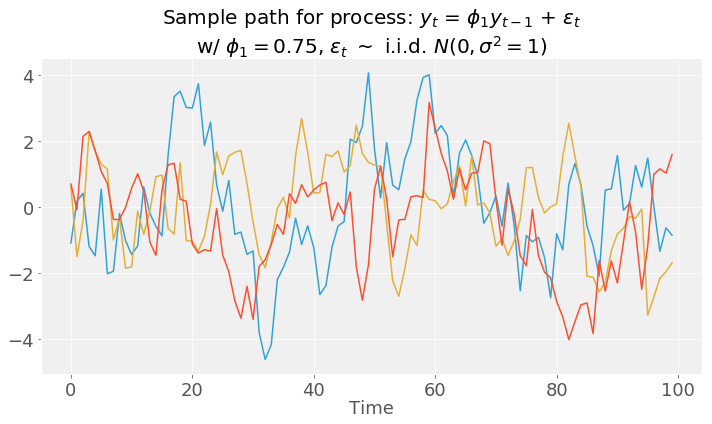

In [4]:
### Simulate an AR(1) process w/ Standard Gaussian shocks
phi1 = 0.75
sigma = 1
np_dist_type, np_dist_params = 'normal', (0, sigma)
ysims1 = simulate_arma(ar_coefs=[1, -phi1], ma_coefs=[1], nsample_T=100, nsims_N=3)

### Plot AR(1) processses w/ Standard Gaussian shocks
fig, axes = plt.subplots(figsize=(10,6))
axes.plot(ysims1)
axes.set_xlabel('Time', fontsize=18)
axes.set_title('Sample path for process: $y_t$ = $\\phi_{1} y_{t-1} $ + $\epsilon_t$ \n' +
               'w/ $\phi_1={:.2f}$, $\epsilon_t$ $\sim$ i.i.d. $N(0, \\sigma^2={:.0f})$'\
               .format(phi1, sigma**2), fontsize=20)

fig.tight_layout()

#### AR($1$) process with $\phi_1=0.75$ and  $\epsilon_t \overset{i.i.d.}{\sim} t(df=2)$:

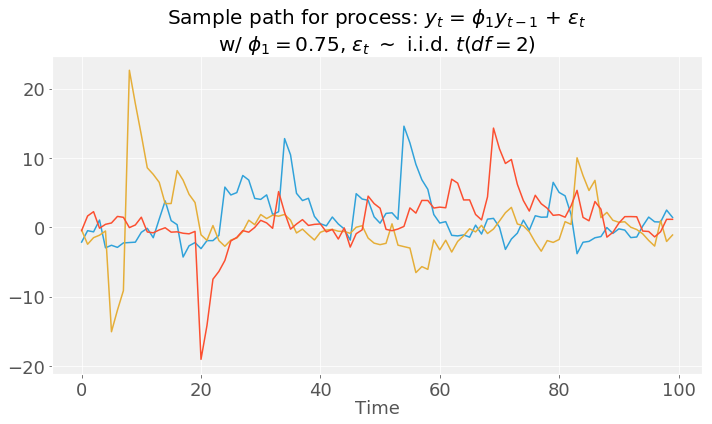

In [5]:
### Simulate an AR(1) process w/ student t-distributed shocks
phi1 = 0.75
df = 2
np_dist_type, np_dist_params = 'standard_t', df
ysims1 = simulate_arma(ar_coefs=[1, -phi1], ma_coefs=[1], nsample_T=100, nsims_N=3)

### Plot AR(1) processses w/ student t-distributed shocks
fig, axes = plt.subplots(figsize=(10,6))
axes.plot(ysims1)
axes.set_xlabel('Time', fontsize=18)
axes.set_title('Sample path for process: $y_t$ = $\\phi_{1} y_{t-1} $ + $\epsilon_t$ \n' +
               'w/ $\phi_1={:.2f}$, $\epsilon_t$ $\sim$ i.i.d. $t(df={:.0f})$'\
               .format(phi1, df), fontsize=20)

fig.tight_layout()

#### AR($2$) process with $\phi_1=0.75$,  $\phi_2=0.5$ and  $\epsilon_t \overset{i.i.d.}{\sim} N(0,4)$:

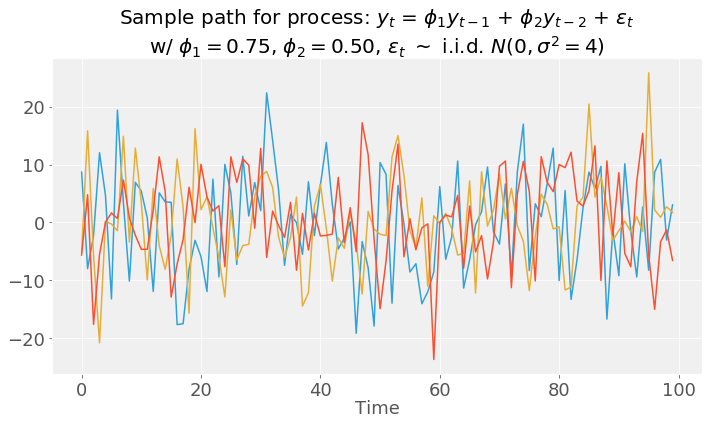

In [6]:
### Simulate an AR(2) process w/ Gaussian shocks
phi1, phi2 = 0.75, 0.5
sigma = 2
np_dist_type, np_dist_params = 'normal', (0, sigma)
ysims1 = simulate_arma(ar_coefs=[1 -phi1 -phi2], ma_coefs=[1], nsample_T=100, nsims_N=3)

### Plot AR(2) processses w/ Gaussian shocks
fig, axes = plt.subplots(figsize=(10,6))
axes.plot(ysims1)
axes.set_xlabel('Time', fontsize=18)
axes.set_title('Sample path for process: $y_t$ = $\\phi_{1} y_{t-1}$ + $\\phi_{2} y_{t-2}$ + $\epsilon_t$ \n' +
               'w/ $\phi_1={:.2f}$, $\phi_2={:.2f}$, $\epsilon_t$ $\sim$ i.i.d. $N(0, \\sigma^2={:.0f})$'\
               .format(phi1, phi2, sigma**2), fontsize=20)

fig.tight_layout()

#### AR($2$) process with $\phi_1=0.75$,  $\phi_2=0.5$ and  $\epsilon_t \overset{i.i.d.}{\sim} t(df=2)$:

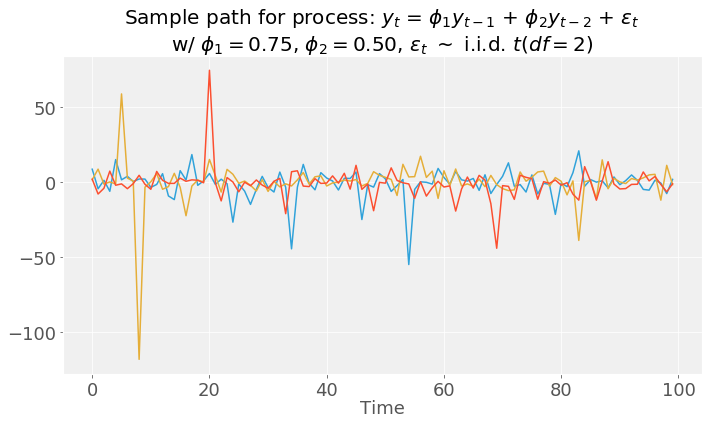

In [7]:
### Simulate an AR(2) process w/ student t-distributed shocks
phi1, phi2 = 0.75, 0.5
df = 2
np_dist_type, np_dist_params = 'standard_t', df
ysims1 = simulate_arma(ar_coefs=[1 -phi1 -phi2], ma_coefs=[1], nsample_T=100, nsims_N=3)

### Plot AR(2) processses w/ student t-distributed shocks
fig, axes = plt.subplots(figsize=(10,6))
axes.plot(ysims1)
axes.set_xlabel('Time', fontsize=18)
axes.set_title('Sample path for process: $y_t$ = $\\phi_{1} y_{t-1}$ + $\\phi_{2} y_{t-2}$ + $\epsilon_t$ \n' +
               'w/ $\phi_1={:.2f}$, $\phi_2={:.2f}$, $\epsilon_t$ $\sim$ i.i.d. $t(df={:.0f})$'\
               .format(phi1, phi2, df), fontsize=20)

fig.tight_layout()

#### MA($1$) process with $\theta_1=0.5$,  and  $\epsilon_t \overset{i.i.d.}{\sim} N(0,4)$:

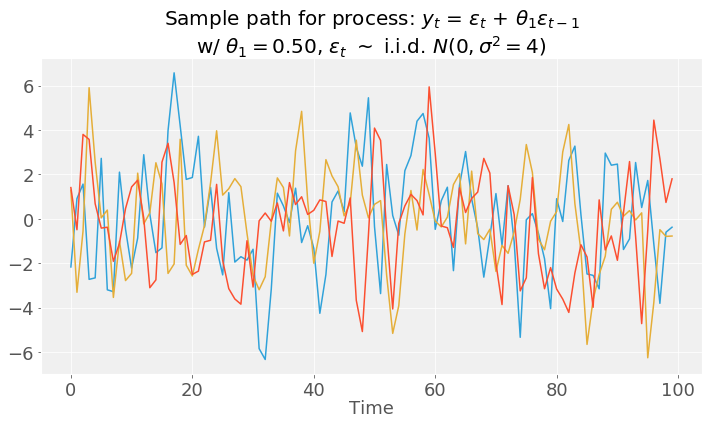

In [8]:
### Simulate an MA(1) process w/ Standard Gaussian shocks
theta1 = 0.5
sigma = 2
np_dist_type, np_dist_params = 'normal', (0, sigma)
ysims2 = simulate_arma(ar_coefs=[1], ma_coefs=[1, theta1], nsample_T=100, nsims_N=3)

### Plot MA(1) processses w/ Standard Gaussian shocks
fig, axes = plt.subplots(figsize=(10,6))
axes.plot(ysims2)
axes.set_xlabel('Time', fontsize=18)
axes.set_title('Sample path for process: $y_t$ = $\epsilon_t$ + $\\theta_{1}\epsilon_{t-1}$\n' +
               'w/ $\\theta_1={:.2f}$, $\epsilon_t$ $\sim$ i.i.d. $N(0, \\sigma^2={:.0f})$'\
               .format(theta1, sigma**2), fontsize=20)

fig.tight_layout()

#### MA($1$) process with $\theta_1=0.5$,  and  $\epsilon_t \overset{i.i.d.}{\sim} t(df=2)$:

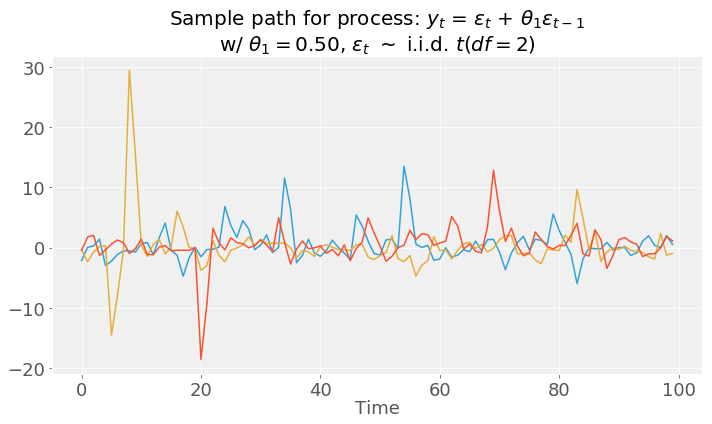

In [9]:
### Simulate an MA(1) process w/ student t-distributed shocks
theta1 = 0.5
df = 2
np_dist_type, np_dist_params = 'standard_t', df
ysims1 = simulate_arma(ar_coefs=[1], ma_coefs=[1, theta1], nsample_T=100, nsims_N=3)

### Plot MA(1) processses w/ student t-distributed shocks
fig, axes = plt.subplots(figsize=(10,6))
axes.plot(ysims1)
axes.set_xlabel('Time', fontsize=18)
axes.set_title('Sample path for process: $y_t$ = $\epsilon_t$ + $\\theta_{1}\epsilon_{t-1}$\n' +
               'w/ $\\theta_1={:.2f}$, $\epsilon_t$ $\sim$ i.i.d. $t(df={:.0f})$'\
               .format(theta1, df), fontsize=20)

fig.tight_layout()

Next, we write a function that effectively acts as a "wrapper" for the `statsmodels` routine `sm.tsa.arma_model.ARMA.fit()` which fits an ARMA($p$,$q$) model by **MLE** using the Kalman filter. 

However, our function will also have the flexibility to simulate $N$ "draws" of sample size $T$ for a given ARMA($p$, $q$), hence we may invoke our previously defined function `simulate_arma` inside this function. Otherwise, we provide the function a 2D `NumPy` array with a set of simulated processes. 

Note, this function will be general enough such that we may simulate an ARMA($p$, $q$) process while estimating it as a separate ARMA($p$, $q$) process <br>
i.e. **We can simulate AR($3$) processes within this function and estimate them as AR($2$)'s.**


The "wrapper" function, `simulate_arma_mle()`, will always include a constant, and provide all output available from the optimization solver.

The default estimation will be that of an MA($1$) process.

In [10]:
def simulate_arma_mle(yprocess=None, ydict=None, x0=None, p_order=0, q_order=1, summary=False, plot_sims=0):          
    """
    MLE estimation of an ARMA(p,q) process via the Kalman Filter
    :PARAM yprocess: 'NumPy' array with time-series realization(s) of observed process
    :PARAM ysim: 'dictionary' for simulating ARMA(p,q) process if yprocess=None
    :PARAM p_order: order of the AR components [default: p_order=0]
    :PARAM q_order: order of the MA components [default: q_order=1]
    :PARAM x0: initial starting values for parameters [default is given by ARMA._fit_start_params if 'None']
    :PARAM summary: 'Bool' object that prints out summary results from MLE estimamtion [default: summary=0]
    :PARAM plot_sims: 'Bool' object that plots the simulated "paths" [default: plot_sims=0]
    :RETURN df_arma_mle: 'DataFrame' object with:
        (1) MLE results, 
        (2) MLE estimated coefficients (ex. intercept), 
        (3) MLE estimated variance of shocks
        (4) MLE convergence (True or False)
    """ 
    try:
        ar_coeffs, ma_coeffs = ydict['ar_coeffs'], ydict['ma_coeffs'] 
        T, N = ydict['nsample_T'], ydict['nsims_N']  
        np_dist_type,  np_dist_params = ydict['np_dist_type'], ydict['np_dist_params'] 

        ### Simulate "N" draws of sample size "T"
        np.random.seed(123)
        yprocess = simulate_arma(ar_coefs=ar_coeffs, ma_coefs=ma_coeffs, nsample_T=T, nsims_N=N)  
    except Exception:
        T, N = yprocess.shape[0], yprocess.shape[1]
       
    ### Plot simualtions of 'yprocess'
    if plot_sims:          
        fig, axes = plt.subplots(figsize=(10,6))
        axes.plot(yprocess)
        axes.set_xlabel('Time', fontsize=18)
        axes.set_title('Sample path for process $y_t$', fontsize=20)  
        fig.tight_layout()    
    
    ### Set up the 'ArmaProcess' objects for MLE estimation (per simulation)
    order_p_q = (p_order, q_order)
     
    ### Pre-allocatte DataFrame with MLE output per simulation. 
    df_arma_mle = pd.DataFrame(index=list(range(0, N)), 
                               columns=['arma_mle_results', 'arma_mle_coeffs', 
                                        'arma_mle_sigma2eps', 'arma_mle_success'])
    
    for ss in range(yprocess.shape[1]):
        arma_model = sm.tsa.ARMA(yprocess[:, ss], order=order_p_q)
        try: 
            df_arma_mle['arma_mle_results'][ss] = arma_model.fit(starting_params=x0, trend='c', maxiter=1000, 
                                                             full_output=True)
        except Exception:
            df_arma_mle['arma_mle_results'][ss] = arma_model.fit(starting_params=np.zeros(np.sum(order_p_q) + 1), 
                                                             trend='c', maxiter=1000, full_output=True)               
        df_arma_mle['arma_mle_coeffs'][ss] = df_arma_mle['arma_mle_results'][ss].params[1:]
        df_arma_mle['arma_mle_sigma2eps'][ss] = df_arma_mle['arma_mle_results'][ss].sigma2   
        df_arma_mle['arma_mle_success'][ss] = df_arma_mle['arma_mle_results'][ss].mle_retvals['converged']
        
        if summary:
            print(df_arma_mle['arma_mle_results'][ss].summary())
                  
    return df_arma_mle


Let's test this function on our process `ysim2` from earlier, which is an MA($1$) process with $\theta_1=0.5$, and $\epsilon_t \overset{i.i.d.}{\sim} N(0,4)$


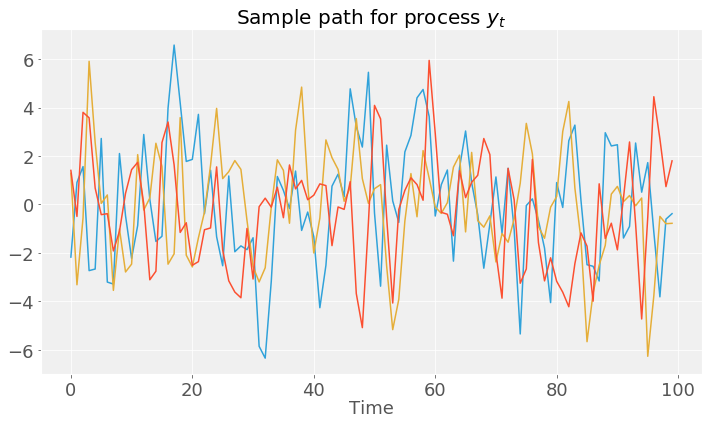

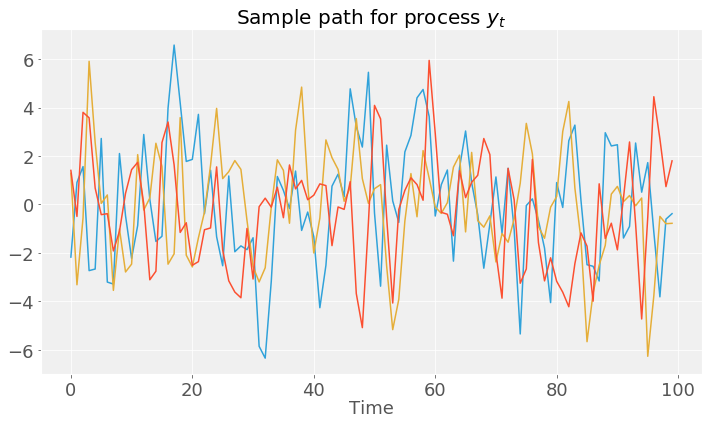

In [11]:
### Version 1: 
df_ma1_v1 = simulate_arma_mle(yprocess=ysims2, ydict=None, x0=None, p_order=0, q_order=1, 
                              summary=False, plot_sims=1)

### Version 2:
theta1 = 0.5
sigma = 2
nsample_T, nsims_N = 100, 3
np_dist_type, np_dist_params = 'normal', (0, sigma)
ydict_ma1 = {'ar_coeffs': [1], 'ma_coeffs': [1, theta1], 
             'nsample_T': nsample_T, 'nsims_N': nsims_N, 
             'np_dist_type': np_dist_type, 'np_dist_params': np_dist_params}

df_ma1_v2 = simulate_arma_mle(yprocess=None, ydict=ydict_ma1, x0=None, p_order=0, q_order=1, 
                              summary=False, plot_sims=1)


### Exercise 2: Part 3

Let's revisit **Example 1** and estimate the parameters of an MA($1$) process via <u>both</u> **MLE** and **GMM**. Let's define a function with moment conditions for **GMM** estimation, `ma1_gmm_moments`.

In the definition of `ma1_gmm_moments`, when the solution(s) to the quadratic equation:

$$
{\widehat{\rho}_1}\widehat{\theta}_1^2 - \widehat{\theta}_1 + {\widehat{\rho}_1}=0  \\
$$
are real and distinct, we use the smallest root, otherwise we ignore and set the **GMM** estimates of both $\widehat{\theta}_1$ and $\widehat{\sigma}_{\epsilon}^2$ to `np.nan`. 

It is worth noting that we estimate $\widehat{\sigma}_{\epsilon}^2$, given the estimate $\widehat{\theta}_1$. This does not account for the uncertainty in $\widehat{\theta}_1$ if we wanted proper standard errors for $\widehat{\sigma}_{\epsilon}^2$. The alternative, which is shown in **Lecture  4 slides**, is to jointly estimate both parameters using moment conditions that incorporate the uncertainty in $\widehat{\theta}_1$ on the estimate $\widehat{\sigma}_{\epsilon}^2$. This can be done as an extension of this example. 

In [12]:
def ma1_gmm_momconds(y): 
    """
    GMM estimate of MA(1) process
    Note: when quadratic equation: rho_hat*theta1_hat**2 - theta1_hat + rho_hat, has complex solutions
          then theta1_hat,  sigma2eps_hat = np.nan, np.nan
    """        
    ### ACF(1): 'fft=True' computes ACF using Fast-Fourier Tranform convolution, 
    ###          which is recommended for "very long time series"
    rho_hat = sm.tsa.acf(y, nlags=1, fft=True)[1]
        
    from sympy import Symbol
    from sympy.solvers import solve
    theta1 = Symbol('theta1')
    roots = np.array([complex(r) for r in solve(rho_hat*(theta1**2) - theta1 + rho_hat, theta1)])
    
    ### GMM estimate of theta1: theta1_hat
    theta1_hat = np.where(np.any(np.iscomplex(roots))==True, np.nan, np.real(roots.min())) 
    #theta1_hat = (1 - np.sqrt(1 - 4*rho_hat**2))/(2*rho_hat)
    
    ### GMM estimate of sigma2eps (variance of epsilon): sigma2eps
    sigma2eps_hat = np.where(np.isnan(theta1_hat), np.nan, np.var(y)/(1 + theta1_hat**2))
    
    ### 'Bool' that =1 if  theta1_hat==np.nan
    gmm_success = np.isnan(theta1_hat)
    
    return theta1_hat, sigma2eps_hat, gmm_success

Let's now compare **MLE** and **GMM** estimates. We can do this by augmenting the function `simulate_arma_mle` from before, and redefining it as `simulate_arma_mle_vs_gmm`.

Moreover, I will define a new function `plot_ma1_mle_vs_gmm` that will show the histogram and provide summary statistics for the estimated MA($1$) **MLE** and **GMM** parameters. 

In [13]:
def simulate_arma_mle_vs_gmm(gmm_est, S0=None, n_iter=None, k_momconds_list=None, 
                             yprocess=None, ydict=None, x0=None, p_order=0, q_order=1, 
                             summary=False, plot_sims=0):          
    """
    Comparison of MLE and GMM estimates for an ARMA(p,q) process via the Kalman Filter
    :PARAM gmm_est: 'string' with function containing the GMM estimation procedure
    :PARAM S0: 'NumPy' array with "S" matrix to be used in general iterated GMM estimation 
               [default: S=None]
    :PARAM n_iter: 'integer' to be used in general iterated GMM estimation [default: n_iter=None]
    :PARAM k_momconds_list: 'tuple' of moment conditions to be used in general GMM estimation 
                            [default: k_momconds_list=None]
    :PARAM yprocess: 'NumPy' array with time-series realization(s) of observed process
    :PARAM ysim: 'dictionary' for simulating ARMA(p,q) process if yprocess=None    
    :PARAM p_order: order of the AR components [default: p_order=0]
    :PARAM q_order: order of the MA components [default: q_order=1]
    :PARAM x0: initial starting values for parameters [default is given by ARMA._fit_start_params if 'None']
    :PARAM summary: 'Bool' object that prints out summary results from MLE estimamtion [default: summary=0]
    :PARAM plot_sims: 'Bool' object that plots the simulated "paths" [default: plot_sims=0]
    :RETURN df_arma_mle, df_arma_gmm: 'DataFrame' objects with:
                    (1) MLE results, 
      df_arma_mle:  (2) MLE estimated coefficients, 
                    (3) MLE estimated variance of shocks
                    (4) MLE convergence
        
                    (1) GMM coefficients
      df_arma_gmm:  (2) GMM estimated variance of shocks
                    (3) GMM 'boolean' for whether solution exists
    """ 
    try:
        ar_coeffs, ma_coeffs = ydict['ar_coeffs'], ydict['ma_coeffs'] 
        T, N = ydict['nsample_T'], ydict['nsims_N']  
        np_dist_type,  np_dist_params = ydict['np_dist_type'], ydict['np_dist_params'] 

        ### Simulate "N" draws of sample size "T"
        np.random.seed(123)
        yprocess = simulate_arma(ar_coefs=ar_coeffs, ma_coefs=ma_coeffs, nsample_T=T, nsims_N=N)  
    except Exception:
        T, N = yprocess.shape[0], yprocess.shape[1]
        
    if plot_sims:    
        ### Plot simualtions of 'yprocess'
        fig, axes = plt.subplots(figsize=(10,6))
        axes.plot(yprocess)
        axes.set_xlabel('Time', fontsize=18)
        axes.set_title('Sample path for process $y_t$', fontsize=20)
        
        fig.tight_layout()    
    
    ### Set up the 'ArmaProcess' objects for MLE estimation (per simulation)
    order_p_q = (p_order, q_order)
     
    ### Pre-allocatte DataFrame with MLE output per simulation. 
    df_arma_mle = pd.DataFrame(index=list(range(0, N)), 
                               columns=['arma_mle_results', 'arma_mle_coeffs', 
                                        'arma_mle_sigma2eps', 'arma_mle_success'])
    df_arma_gmm = pd.DataFrame(index=list(range(0, N)), 
                               columns=['arma_gmm_coeffs', 'arma_gmm_sigma2eps', 'arma_gmm_success'])
    
    ### Loop through simulations...
    for ss in range(yprocess.shape[1]):       
          
        ### 1. MLE
        arma_model = sm.tsa.ARMA(yprocess[:, ss], order=order_p_q)
        try: 
            df_arma_mle['arma_mle_results'][ss] = arma_model.fit(starting_params=x0, trend='c', maxiter=1000, 
                                                                     full_output=True)
        except Exception:
            df_arma_mle['arma_mle_results'][ss] = arma_model.fit(starting_params=np.zeros(np.sum(order_p_q) + 1), 
                                                                     trend='c', maxiter=1000, full_output=True)  
               
        df_arma_mle['arma_mle_coeffs'][ss] = df_arma_mle['arma_mle_results'][ss].params[1:]
        df_arma_mle['arma_mle_sigma2eps'][ss] = df_arma_mle['arma_mle_results'][ss].sigma2   
        df_arma_mle['arma_mle_success'][ss] = df_arma_mle['arma_mle_results'][ss].mle_retvals['converged']
        
        ### 2. GMM   
        if k_momconds_list==None:
            arma_coefs_hat, sigma2eps_hat, gmm_success = globals()[gmm_est](yprocess[:,ss])
        else:
            if S0==None:
                arma_coefs_hat, sigma2eps_hat, gmm_success = \
                    globals()[gmm_est](yprocess[:,ss], n_iter=n_iter, k_momconds_list=k_momconds_list)
            else:
                arma_coefs_hat, sigma2eps_hat, gmm_success = \
                    globals()[gmm_est](yprocess[:,ss], S0=S0, n_iter=n_iter, k_momconds_list=k_momconds_list) 
        
        df_arma_gmm['arma_gmm_coeffs'][ss] = arma_coefs_hat
        df_arma_gmm['arma_gmm_sigma2eps'][ss] = sigma2eps_hat
        df_arma_gmm['arma_gmm_success'][ss] = gmm_success
        
        
    return df_arma_mle, df_arma_gmm

In [25]:
def plot_ma1_mle_vs_gmm(df_ma1_mle, df_ma1_gmm, theta1, sigma2eps):
    
    ### Plot the empirical distribution of empirical estimates
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,22))
    
    ma1_mle_label1 = 'Mean$(\widehat\\theta_1)$ = {:.3f}\nStdDev$(\widehat\\theta_1)$ = {:.3f}'\
                     .format(np.nanmean(df_ma1_mle['arma_mle_coeffs']).item(), 
                             np.nanstd(df_ma1_mle['arma_mle_coeffs']).item()) 
    
    ma1_mle_label2 = 'Mean$(\widehat\\sigma_\epsilon^2)$ = {:.3f}\nStdDev$(\widehat\\sigma_\epsilon^2)$ = {:.3f}'\
                     .format(np.nanmean(df_ma1_mle['arma_mle_sigma2eps']).item(), 
                             np.nanstd(df_ma1_mle['arma_mle_sigma2eps']).item()) 
    
    ma1_gmm_label1 = 'Mean$(\widehat\\theta_1)$ = {:.3f}\nStdDev$(\widehat\\theta_1)$ = {:.3f}'\
                     .format(np.nanmean(df_ma1_gmm['arma_gmm_coeffs']).item(), 
                             np.nanstd(df_ma1_gmm['arma_gmm_coeffs']).item()) 
    ma1_gmm_label2 = 'Mean$(\widehat\\sigma_\epsilon^2)$ = {:.3f}\nStdDev$(\widehat\\sigma_\epsilon^2)$ = {:.3f}'\
                     .format(np.nanmean(df_ma1_gmm['arma_gmm_sigma2eps']).item(), 
                             np.nanstd(df_ma1_gmm['arma_gmm_sigma2eps']).item())    
    
    ### theta1
    axes[0,0].hist(np.concatenate(df_ma1_mle['arma_mle_coeffs']), bins=50, density=True, 
                   edgecolor="black", label=ma1_mle_label1)
    axes[0,0].set_title('MLE: $\widehat\\theta$', fontsize=24)   
    ymin, ymax = axes[0,0].get_ylim()
    axes[0,0].plot((theta1, theta1), (ymin, ymax), 'r--')    
    axes[0,0].legend(fontsize=22) 
    
    axes[0,1].hist(np.array(df_ma1_gmm['arma_gmm_coeffs'].tolist()), bins=50, density=True,
                   edgecolor="black", label=ma1_gmm_label1)
    axes[0,1].set_title('GMM: $\widehat\\theta$', fontsize=24)   
    ymin, ymax = axes[0,1].get_ylim()
    axes[0,1].plot((theta1, theta1), (ymin, ymax), 'r--')      
    axes[0,1].legend(fontsize=22) 
    
    ### sigma2eps
    axes[1,0].hist(np.array(df_ma1_mle['arma_mle_sigma2eps'].tolist()), bins=50, density=True, 
                   edgecolor="black", label=ma1_mle_label2)
    axes[1,0].set_title('MLE: $\widehat\\sigma_\epsilon^2$', fontsize=24)    
    ymin, ymax = axes[1,0].get_ylim()
    axes[1,0].plot((sigma2eps, sigma2eps), (ymin, ymax), 'r--')    
    axes[1,0].legend(fontsize=22) 
    
    axes[1,1].hist(np.array(df_ma1_gmm['arma_gmm_sigma2eps'].tolist()), bins=50, density=True, 
                   edgecolor="black", label=ma1_gmm_label2)
    axes[1,1].set_title('GMM: $\widehat\\sigma_\epsilon^2$', fontsize=24)      
    ymin, ymax = axes[1,1].get_ylim()
    axes[1,1].plot((sigma2eps, sigma2eps), (ymin, ymax), 'r--')  
    axes[1,1].legend(fontsize=22) 
    
    return fig
       

Now, let's compare **MLE** and **GMM** estimates $\widehat{\theta}_1$ and $\widehat{\sigma}_{\epsilon}^2$ for an MA($1$) process with "true" parameter values of $\theta_1=0.5$ and $\sigma_{\epsilon}^2=4$. 

Let's use the function `monte_carlo_stats` from earlier labs to get Monte Carlos summary statistics. Let's consider sample size $T=75$.

In [26]:
def monte_carlo_stats(np_coef, nsample, percentiles, estimator):
    coef_desc_T = pd.DataFrame(np_coef).describe(percentiles=percentiles)
    coef_desc_cols = "{}".format(estimator + ': T=' + str(nsample)) 
    coef_desc_T.rename(columns={0: coef_desc_cols}, inplace=True)
    coef_desc_T.loc['count'] = coef_desc_T.loc['count'].apply('{:.0f}'.format)
    return coef_desc_T

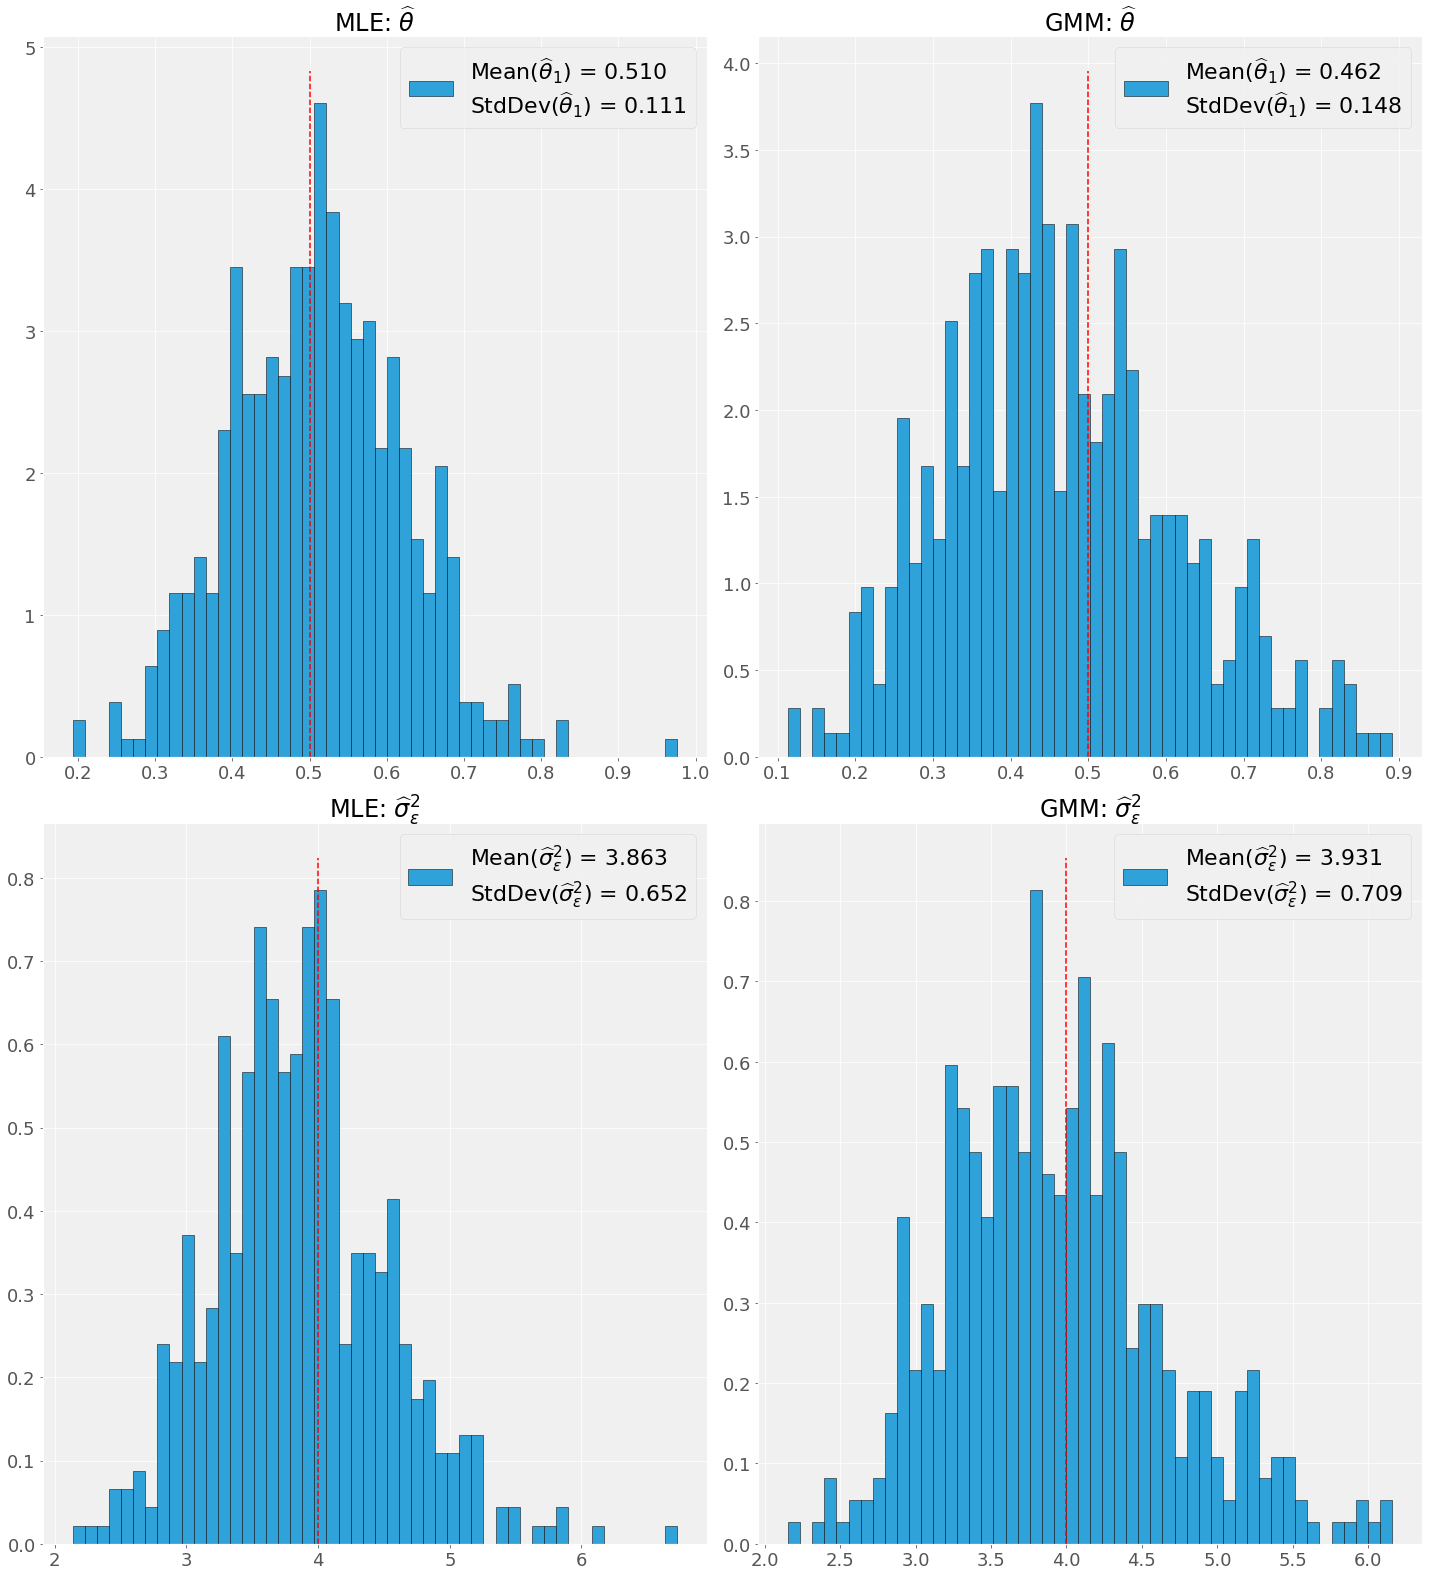

In [27]:
theta1 = 0.5
sigma = 2
nsample_T, nsims_N =75, 500
np_dist_type, np_dist_params = 'normal', (0, sigma)
ydict_ma1 = {'ar_coeffs': [1], 'ma_coeffs': [1, theta1], 
             'nsample_T': nsample_T, 'nsims_N': nsims_N, 
             'np_dist_type': np_dist_type, 'np_dist_params': np_dist_params}

### Simulate 'nsims_N' paths with sample size 'nsample_T'
gmm_est = 'ma1_gmm_momconds'
df_ma1_mle, df_ma1_gmm = simulate_arma_mle_vs_gmm(gmm_est=gmm_est, yprocess=None, 
                                                  ydict=ydict_ma1, x0=None, p_order=0, q_order=1, 
                                                  summary=False, plot_sims=0)

### Histogram of empirical estimates
fig = plot_ma1_mle_vs_gmm(df_ma1_mle, df_ma1_gmm, theta1=theta1, sigma2eps=sigma**2)
fig.tight_layout()  

The Monte Carlo summary statistics are found below:

In [28]:
### theta1
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=np.concatenate(df_ma1_mle['arma_mle_coeffs']), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=np.array(df_ma1_gmm['arma_gmm_coeffs'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T

mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.510,0.111,0.193,0.271,0.327,0.371,0.431,0.510,0.583,0.658,0.685,0.765,0.975
GMM: T=75,461,0.462,0.148,0.114,0.177,0.247,0.277,0.359,0.447,0.555,0.668,0.727,0.833,0.891


In [29]:
### sigma2eps
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=np.array(df_ma1_mle['arma_mle_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=np.array(df_ma1_gmm['arma_gmm_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,3.863,0.652,2.137,2.475,2.866,3.035,3.459,3.834,4.252,4.674,4.988,5.700,6.723
GMM: T=75,461,3.931,0.710,2.156,2.491,2.887,3.063,3.416,3.870,4.324,4.902,5.249,5.918,6.157


### Exercise 2: Part 3 (Digression)

Now let's suppose we simulate an MA($2$) process with $\theta_1=0.5$, $\theta_2=0.8$, and $\epsilon_t \overset{i.i.d.}{\sim} WN(0, 4)$ <br>
i.e. the "true model" is:
$$ 
y_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} \\
\epsilon_t \overset{i.i.d.}{\sim} WN(0,\sigma_\epsilon^2) \\
\theta_1 =0.5, \theta_2=0.8, \sigma_\epsilon^2=4
$$

BUT, we instead estimate it as an MA($1$) process using both **MLE** and **GMM** (with **MLE** assuming $\epsilon_t$ is Gaussian). 

#### Question: How will our **MLE** and **GMM** estimates differ? 
Let's find out....

In [30]:
### Simulate an MA(2) process w/ Standard Gaussian shocks
theta1, theta2 = 0.5, 0.8
sigma = 2
nsample_T, nsims_N = 75, 500
np_dist_type, np_dist_params = 'normal', (0, sigma)
ysims1 = simulate_arma(ar_coefs=[1], ma_coefs=[1, theta1, theta2], nsample_T=nsample_T, nsims_N=nsims_N)

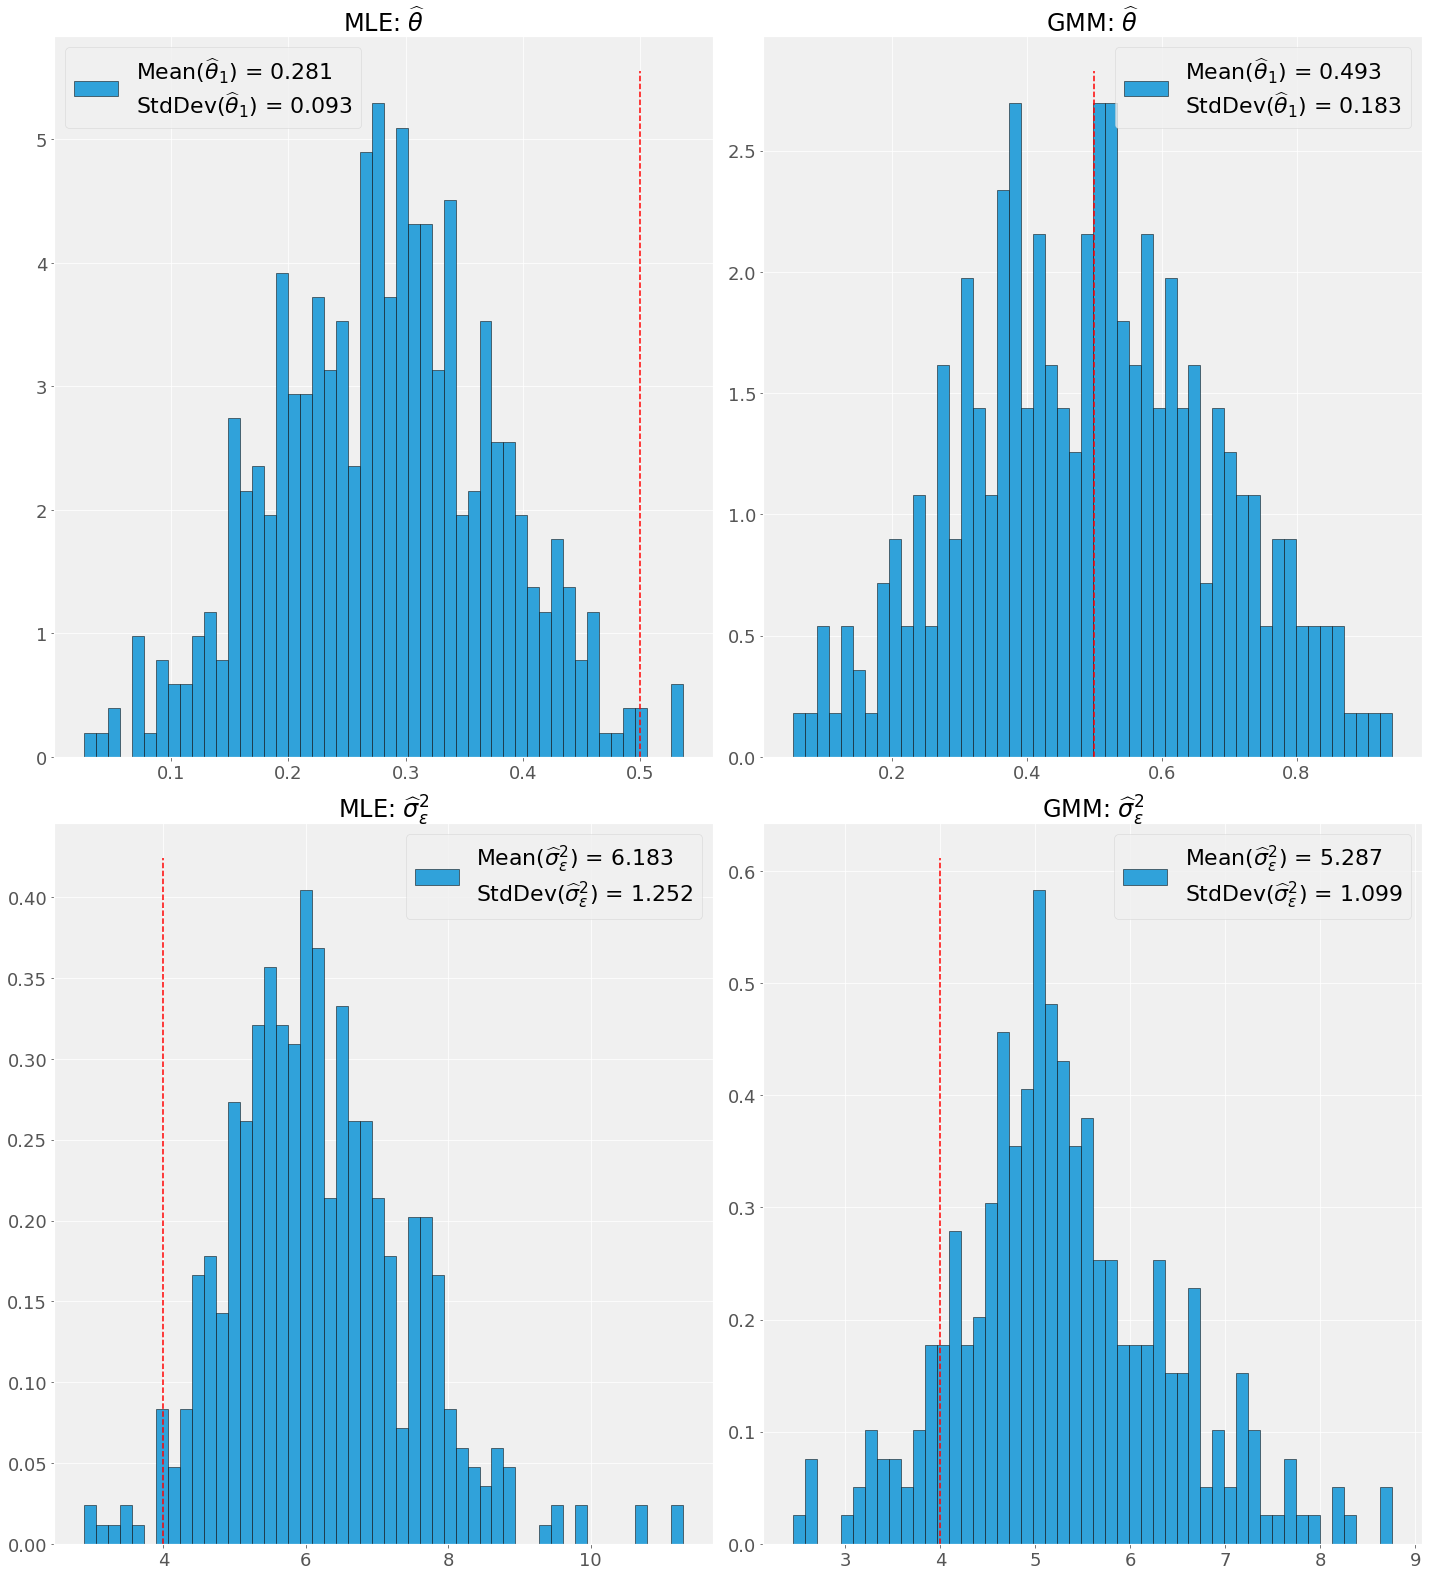

In [31]:
### MLE vs. GMM: MA(2)
gmm_est = 'ma1_gmm_momconds'
df_ma1_mle_miss, df_ma1_gmm_miss = simulate_arma_mle_vs_gmm(gmm_est=gmm_est, yprocess=ysims1, 
                                                            ydict=None, x0=None, p_order=0, q_order=1, 
                                                            summary=False, plot_sims=0)

### Histogram of empirical estimates
fig = plot_ma1_mle_vs_gmm(df_ma1_mle_miss, df_ma1_gmm_miss, theta1=theta1, sigma2eps=sigma**2)
fig.tight_layout()  

The Monte Carlo summary statistics are found below.

In [32]:
### theta1
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=np.concatenate(df_ma1_mle_miss['arma_mle_coeffs']), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=np.array(df_ma1_gmm_miss['arma_gmm_coeffs'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.281,0.093,0.026,0.072,0.131,0.162,0.215,0.283,0.341,0.401,0.435,0.493,0.536
GMM: T=75,313,0.493,0.183,0.053,0.100,0.194,0.261,0.365,0.498,0.618,0.737,0.797,0.874,0.942


In [33]:
### sigma2eps
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=np.array(df_ma1_mle_miss['arma_mle_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=np.array(df_ma1_gmm_miss['arma_gmm_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,6.183,1.254,2.888,3.547,4.403,4.722,5.310,6.057,6.908,7.775,8.271,9.812,11.299
GMM: T=75,313,5.287,1.101,2.449,2.709,3.564,3.973,4.624,5.165,5.928,6.687,7.233,8.204,8.755


#### Discussion:

Clearly, the **maximum likelihood estimates** are not as robust as the **GMM** estimates, given the strong distributional assumptions we made.

### Exercise 2: Part 4 

Let's now compare **MLE** and **GMM** estimates for AR($p$) models.

Let's consider an AR($2$) model with $\phi_1=0.5$, $\phi_2=0.1$, and $\epsilon_t \overset{i.i.d.}{\sim} WN(0, 4)$ <br>
i.e. the "true model" is:
$$ 
y_t = \mu + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t\\
\epsilon_t \overset{i.i.d.}{\sim} WN(0,\sigma_\epsilon^2) \\
\phi_1 =0.5, \phi_2=0.1, \sigma_\epsilon^2=4
$$

We can easily verify that this model doesn't have a unit root using user-defined functions from earlier labs:

In [34]:
def compute_root(ar_coef):
    ar_coef = np.array(ar_coef)
    ar_coef = -np.flip(ar_coef.flatten())
    ar_coef = np.concatenate((ar_coef, [1]))
    roots = np.roots(ar_coef)
    return roots

In [35]:
##### Commpute roots:
phi1, phi2 = 0.5, 0.1
ar2_roots = compute_root([phi1, phi2])
print('AR(2) process has roots: {:.3f} and {:.3f}'.format(ar2_roots[0], ar2_roots[1]))

AR(2) process has roots: -6.531 and 1.531


For an AR(2), we can use the *ACF* at various lags to obtain moment conditions. This will equivalent to using the orthogonality conditions that map directly to **GMM** moment conditions.

### Moment Conditions:
Since $\{\epsilon_t\}_{t\geq0}$ is the innovation process of  $\{y\}_{t\geq0}$, we have the following orthogonality conditions: $E\left[y_{t-j}\epsilon_t\right] = 0, \; j >1$ i.e. pre-determined values $y_{t-2}, y_{t-3}, y_{t-h}$ can be used as instruments, which we store in the vector $\mathbf{z}_t$:

$$
\mathbf{z}_t = \left[y_{t-2}, y_{t-3},..., y_{t-h}\right]^{'}
$$

where $(h-1) \geq$ # of $\phi_i$'s (here, 2). Moreover, we have $E\left[\epsilon_t^2\right] = \sigma_{\epsilon}^2$, which appears in the variance of $y_t$ as follows: 

$$
E\left[y_t^2 \right] = \phi_1 E\left[ y_{t-1}y_t \right] + \phi_2 E\left[y_{t-2}y_t \right] + \sigma_{\epsilon}^2 \\
\implies \gamma_0 = \phi_1 \gamma_1 + \phi_2 \gamma_2  + \sigma_{\epsilon}^2 \\
\implies \gamma_0 = \phi_1 \rho_1 \gamma_0 + \phi_2 \rho_2 \gamma_0  + \sigma_{\epsilon}^2 \\
$$

where $\gamma_j$ and $\rho_j$ are the $j^{th}$-order autocovariance and autocorrelation (*ACF*) functions, respectively. After doing some algebra, another moment condition is:
$$ 
E\left[y_t^2 - \phi_1 y_{t-1} y_t -\phi_2 y_{t-2} y_t -\sigma_{\epsilon}^2\right] =0
$$

Let $\mathbf{\beta}$ denote the parameter vector i.e. $\mathbf{\beta}= \left[ \phi_1, \phi_2, \sigma_{\epsilon}^2 \right]$. The **GMM** moment conditions will have the form: 

$$
E\left[\mathbf{h}(\mathbf{\beta}, \mathbf{z}_t) \right] = \mathbf{0}_{\left[(h-1)\times 1\right]} \\
w/ \; \mathbf{h}(\mathbf{\beta}, \mathbf{z}_t) = 
\left[ 
\begin{array}{c}
    y_t (y_t - \phi_1 y_{t-1} - \phi_2 y_{t-2}) - \sigma_{\epsilon}^2 \\
    \mathbf{z}_t (y_t - \phi_1 y_{t-1} - \phi_2 y_{t-2})
\end{array}
\right]
$$

with the empirical counterpart defined to be: 

$$
 \mathbf{g}(\mathbf{\beta}, \mathbf{Z}_T)\equiv \left[ 
 \begin{array}{c}
  \frac{1}{T} \sum_{t=h+1}^{T} \{y_t (y_t - \phi_1 y_{t-1} - \phi_2 y_{t-2})\} - \sigma_{\epsilon}^2  \\
  \frac{1}{T} \sum_{t=h+1}^{T} \{y_{t-2} (y_t - \phi_1 y_{t-1} - \phi_2 y_{t-2}) \} \\
  \frac{1}{T} \sum_{t=h+1}^{T} \{y_{t-3} (y_t - \phi_1 y_{t-1} - \phi_2 y_{t-2}) \} \\
  \frac{1}{T} \sum_{t=h+1}^{T} \{y_{t-4} (y_t - \phi_1 y_{t-1} - \phi_2 y_{t-2}) \} \\
  ... \\
  \frac{1}{T} \sum_{t=h+1}^{T} \{y_{t-h} (y_t - \phi_1 y_{t-1} - \phi_2 y_{t-2}) \} \\
  \end{array}
  \right]
$$

where $\mathbf{Z}_T\equiv \left[\mathbf{z}_1^{'}, \mathbf{z}_2^{'},...,\mathbf{z}_T^{'} \right]^{'}$


However, we can also rewrite the moment conditions in terms of the *ACF* for the AR($2$) process. The *ACF* is given by
$$
\rho_1 = \frac{\phi_1}{1 - \phi_2} \\
\rho_j = \phi_1 \rho_{j-1} + \phi_2  \rho_{j-2}, \; j>1
$$

The relation above is related to the **Yule-Walker equations**, which cast the *ACF* of an AR($p$) process as a recurrent relation with initial condition(s).

Thus, another way to write the **GMM** moment conditions is as follows:
$$
 E\left[\mathbf{h}(\mathbf{\beta}, \mathbf{z}_t)\right] \equiv \left[ 
 \begin{array}{c}
  1 - \phi_1 \rho_1  - \phi_2 \rho_2 - \sigma_\epsilon^2\\
  \rho_1 - \phi_1 - \phi_2 \rho_1 \\
  \rho_2 - \phi_1 \rho_1  - \phi_2 \\
  \rho_3 - \phi_1 \rho_2  - \phi_2 \rho_1 \\
  ... \\
  \rho_{h-1} - \phi_1 \rho_{h-2}  - \phi_2 \rho_{h-3} \\
  \end{array}
  \right]
$$

with empirical counterparts:

$$
 \mathbf{g}(\mathbf{\beta}, \mathbf{Z}_T)\equiv \left[ 
 \begin{array}{c}
  1 - \widehat{\phi}_1 \widehat{\rho}_1  - \widehat{\phi}_2 \widehat{\rho}_2 - \widehat{\sigma}_\epsilon^2\\
  \widehat{\rho}_1 - \widehat{\phi}_1 - \widehat{\phi}_2 \widehat{\rho}_1 \\
  \widehat{\rho}_2 - \widehat{\phi}_1 \widehat{\rho}_1 - \widehat{\phi}_2 \\
  \widehat{\rho}_3 - \widehat{\phi}_1 \widehat{\rho}_2 - \widehat{\phi}_2 \widehat{\rho}_1 \\
  ... \\
  \widehat{\rho}_{h-1} - \widehat{\phi}_1 \widehat{\rho}_{h-2} - \widehat{\phi}_2 \widehat{\rho}_{h-3} \\
  \end{array}
  \right]
$$

If we don't care about the standard error of the estimate $\widehat{\sigma}_\epsilon^2$, then we can simply throw away the $1^{st}$ moment condition and simply use the estimate 
$$
\widehat{\sigma}_\epsilon^2= \widehat{Var}(y_t) \frac{(1 + \widehat{\phi}_2)((1 - \widehat{\phi}_2)^2 - \widehat{\phi}_1^2)}{(1 - \widehat{\phi}_2)}
$$


We need to estimate $\phi_1$, $\phi_2$, and $\sigma_{\epsilon}^2$ (with $\epsilon_t \overset{i.i.d.}{\sim} WN(0,\sigma_\epsilon^2)$). A *just-identified* model will use as many moment conditions as parameters to estimate (here, 3), while an *over-identified* model will use more moment conditions than parameters. We can choose which route to take based on the **GMM** weight matrix $W$ that we choose to use. 

Our **GMM** estimator of $\mathbf{\beta}= \left[ \phi_1, \phi_2, \sigma_{\epsilon}^2 \right]$ is the value that minimizes the scalar: 

$$
Q(\mathbf{\beta}, \mathbf{Z}_T) = \left[\mathbf{g}(\mathbf{\beta},  \mathbf{Z}_T)\right]^{'}W \left[\mathbf{g}(\mathbf{\beta},  \mathbf{Z}_T) \right]
$$

where $W$ is an $r \times r$ positive-definite weighting matrix. When $r=3$, which is the number of parameters to be estimate, then we are in the Method of Moments world (as in **Example 1**). The objective function will be minimized  by setting $\mathbf{g}(\widehat{\mathbf{\beta}}^{MM}, \mathbf{Z}_T)$.

Let's start by considering an over-identified model with $h=4$. We will ignore the moment condition that gives us $\sigma_{\epsilon}^2$ in the GMM estimation and simply estimate it given $\widehat{\phi}_1$ and $\widehat{\phi}_2$. Thus, we use one additional moment condition than is needed: we will have $r=3$ moment conditions. 

In [36]:
def ar2_gmm_momconds(y, beta, k_momconds_list=(2,3,4)):
    """
    GMM stacked moment conditions 
    (using direct computation of ACFs)
    """
    
    ### ACF(j): 'fft=True' computes ACF using Fast-Fourier Tranform convolution, 
    ###          which is recommended for "very long time series"  
    Nobs = y.shape[0]
    if min(k_momconds_list)==1:
        k_momconds = len(k_momconds_list)-1
    else:
        k_momconds = len(k_momconds_list)
    g = np.zeros((Nobs, len(k_momconds_list)))    
    acf_j = sm.tsa.acf(y, nlags=k_momconds, fft=True)
    
    ### Extract "beta"
    if min(k_momconds_list)==1:
        phi1, phi2, sigma2eps = beta
    else: 
        phi1, phi2 = beta

    ### stack GMM moment conditions...
    for idx, k in enumerate(k_momconds_list):
        if min(k_momconds_list)==1:
            if idx==0:
                g[:, idx] = 1 - phi1*acf_j[1] - phi2*acf_j[2] - sigma2eps
            elif idx==1:  
                g[:, idx] = acf_j[1] - phi1 - phi2*acf_j[1]
            else:    
                g[:, idx] = acf_j[idx] - phi1*acf_j[idx - 1] - phi2*acf_j[idx - 2]
        else:
            if idx==0:
                g[:, idx] = acf_j[1] - phi1 - phi2*acf_j[1]
            else:
                g[:, idx] = acf_j[idx + 1] - phi1*acf_j[idx] - phi2*acf_j[idx - 1]
    
    return g

In [37]:
def ar2_gmm_Smat(y, beta, k_momconds_list=(2,3,4)):
    """
    S hat matrix:
    NOTE: uses 'ar2_gmm_momconds1'
    """
    Nobs = y.shape[0]
    g = ar2_gmm_momconds(y, beta, k_momconds_list=k_momconds_list)
    S_hat = np.dot(g.T, g)/Nobs
    return S_hat
    

def ar2_gmm_objfun(y, beta, S=None, k_momconds_list=(2,3,4)):
    """
    GMM objective function Q(beta, Z_T)
    :PARAM y: data vector
    :PARAM ar2_beta: parameter vector
    :PARAM S: inverse of weight matrix W
    :PARA k_momconds_list: 'list' of moment conditions
     NOTE: uses 'ar2_gmm_momconds1'
    """
    k_momconds = len(k_momconds_list)
    
    ### S=None, use identity matrix I
    if S is None:
        S = np.eye(k_momconds)     
    h = ar2_gmm_momconds(y, beta, k_momconds_list=k_momconds_list)
    g_mean = h.mean(axis=0)
    W = np.linalg.inv(S)
    gtWg = np.dot(np.dot(g_mean.T, W), g_mean)
    return gtWg 

def ar2_gmm_est(y, S=None, k_momconds_list=(2,3,4)):
    """
    GMM estimation routine: minimization of objective function
    """
    ### scalar minimization of Q(beta, Z_T)
    Q = lambda beta: ar2_gmm_objfun(y, beta, S=S, k_momconds_list=k_momconds_list)
    if min(k_momconds_list)==1:
        x0 = [0.1, 0.1, 1]
    else:  
        x0 = [0.1, 0.1]
    Q_res = scipy.optimize.minimize(Q, x0)
    if Q_res.success:
        ar2_beta_hat = Q_res.x
        gmm_success = True
    else:
        if min(k_momconds_list)==1:
            ar2_beta_hat = [np.nan, np.nan, np.nan]
        else:   
            ar2_beta_hat = [np.nan, np.nan]
        gmm_success = False
    return ar2_beta_hat, gmm_success


def ar2_gmm_est_iter(y, S0=None, n_iter=0, k_momconds_list=(2,3,4)):
    """
    Iterated GMM estimation routine: calls on 'ar2_gmm_estimation'
    """
    ### scalar minimization of Q(beta, Z_T)
    S = S0
    for idx in range(n_iter + 1):
        ar2_beta_hat, gmm_success = ar2_gmm_est(y, S=S, k_momconds_list=k_momconds_list)
        S = ar2_gmm_Smat(y, ar2_beta_hat, k_momconds_list=k_momconds_list) 
    
    if min(k_momconds_list)==1:
        ar2_phis_hat  = ar2_beta_hat[:-1] 
        ar2_sigma2eps = ar2_beta_hat[-1] 
    else:
        ar2_phis_hat  = ar2_beta_hat
        ar2_sigma2eps = np.var(y)*((1 + ar2_phis_hat[1])*((1 - ar2_phis_hat[1])**2 - ar2_phis_hat[0]**2))/(1 - ar2_phis_hat[1])       
    
    return ar2_phis_hat, ar2_sigma2eps, gmm_success

In [38]:
def plot_ar2_mle_vs_gmm(df_ar2_mle, df_ar2_gmm, phi1, phi2, sigma2eps, gmm_est_str='GMM'):
    
    ### Extract coefficients:
    phi1_mle = df_ar2_mle['arma_mle_coeffs'].apply(lambda x: x[0]).values
    phi2_mle = df_ar2_mle['arma_mle_coeffs'].apply(lambda x: x[1]).values
    
    phi1_gmm = df_ar2_gmm['arma_gmm_coeffs'].apply(lambda x: x[0]).values
    phi2_gmm = df_ar2_gmm['arma_gmm_coeffs'].apply(lambda x: x[1]).values
    
    ### Plot the empirical distribution of empirical estimates
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 22))
    
    ar2_mle_label1 = 'Mean$(\widehat\\phi_1)$ = {:.3f}\nStdDev$(\widehat\\phi_1)$ = {:.3f}'\
                     .format(np.nanmean(phi1_mle), np.nanstd(phi1_mle)) 
    
    ar2_mle_label2 = 'Mean$(\widehat\\phi_2)$ = {:.3f}\nStdDev$(\widehat\\phi_2)$ = {:.3f}'\
                     .format(np.nanmean(phi2_mle), np.nanstd(phi2_mle)) 
    
    ar2_mle_label3 = 'Mean$(\widehat\\sigma_\epsilon^2)$ = {:.3f}\nStdDev$(\widehat\\sigma_\epsilon^2)$ = {:.3f}'\
                     .format(np.nanmean(df_ar2_mle['arma_mle_sigma2eps']).item(), 
                             np.nanstd(df_ar2_mle['arma_mle_sigma2eps']).item()) 
    
    
    ar2_gmm_label1 = 'Mean$(\widehat\\phi_1)$ = {:.3f}\nStdDev$(\widehat\\phi_1)$ = {:.3f}'\
                     .format(np.nanmean(phi1_gmm), np.nanstd(phi1_gmm)) 
    
    ar2_gmm_label2 = 'Mean$(\widehat\\phi_2)$ = {:.3f}\nStdDev$(\widehat\\phi_2)$ = {:.3f}'\
                     .format(np.nanmean(phi2_gmm), np.nanstd(phi2_gmm))    
    
    ar2_gmm_label3 = 'Mean$(\widehat\\sigma_\epsilon^2)$ = {:.3f}\nStdDev$(\widehat\\sigma_\epsilon^2)$ = {:.3f}'\
                     .format(np.nanmean(df_ar2_gmm['arma_gmm_sigma2eps']).item(), 
                             np.nanstd(df_ar2_gmm['arma_gmm_sigma2eps']).item())    
    
    
    ### phi1
    axes[0,0].hist(phi1_mle, bins=50, density=True, edgecolor="black", label=ar2_mle_label1)
    axes[0,0].set_title('MLE: $\widehat\\phi_1$', fontsize=24)    
    ymin, ymax = axes[0,0].get_ylim()
    axes[0,0].plot((phi1, phi1), (ymin, ymax), 'r--')    
    axes[0,0].legend(fontsize=22) 
    
    
    axes[0,1].hist(phi1_gmm, bins=50, density=True, edgecolor="black", label=ar2_gmm_label1)
    axes[0,1].set_title(gmm_est_str + ': $\widehat\\phi_1$', fontsize=24)    
    ymin, ymax = axes[0,1].get_ylim()
    axes[0,1].plot((phi1, phi1), (ymin, ymax), 'r--')      
    axes[0,1].legend(fontsize=22) 
    
    
    ### phi2
    axes[1,0].hist(phi2_mle, bins=50, density=True, edgecolor="black", label=ar2_mle_label2)
    axes[1,0].set_title('MLE: $\widehat\\phi_2$', fontsize=24)   
    ymin, ymax = axes[1,0].get_ylim()
    axes[1,0].plot((phi2, phi2), (ymin, ymax), 'r--')    
    axes[1,0].legend(fontsize=22) 
    
    
    axes[1,1].hist(phi2_gmm, bins=50, density=True, edgecolor="black", label=ar2_gmm_label2)
    axes[1,1].set_title(gmm_est_str + ': $\widehat\\phi_2$', fontsize=24)   
    ymin, ymax = axes[1,1].get_ylim()
    axes[1,1].plot((phi2, phi2), (ymin, ymax), 'r--')      
    axes[1,1].legend(fontsize=22) 
    
    
    ### sigma2eps
    axes[2,0].hist(np.array(df_ar2_mle['arma_mle_sigma2eps'].tolist()), bins=50, density=True, 
                   edgecolor="black", label=ar2_mle_label3)
    axes[2,0].set_title('MLE: $\widehat\\sigma_\epsilon^2$', fontsize=24)  
    ymin, ymax = axes[2,0].get_ylim()
    axes[2,0].plot((sigma2eps, sigma2eps), (ymin, ymax), 'r--')    
    axes[2,0].legend(fontsize=22) 
    
    
    axes[2,1].hist(np.array(df_ar2_gmm['arma_gmm_sigma2eps'].tolist()), bins=50, density=True, 
                   edgecolor="black", label=ar2_gmm_label3)
    axes[2,1].set_title(gmm_est_str + ': $\widehat\\sigma_\epsilon^2$', fontsize=24)  
    ymin, ymax = axes[2,1].get_ylim()
    axes[2,1].plot((sigma2eps, sigma2eps), (ymin, ymax), 'r--')  
    axes[2,1].legend(fontsize=22) 
    
    return fig
       

Let's simulate our AR($2$) process $N=500$ times with each "path" having a sample size of $T=75$. 

Then, let's compare **MLE** and **GMM** estimates with **GMM** weight matrix $W=I$.

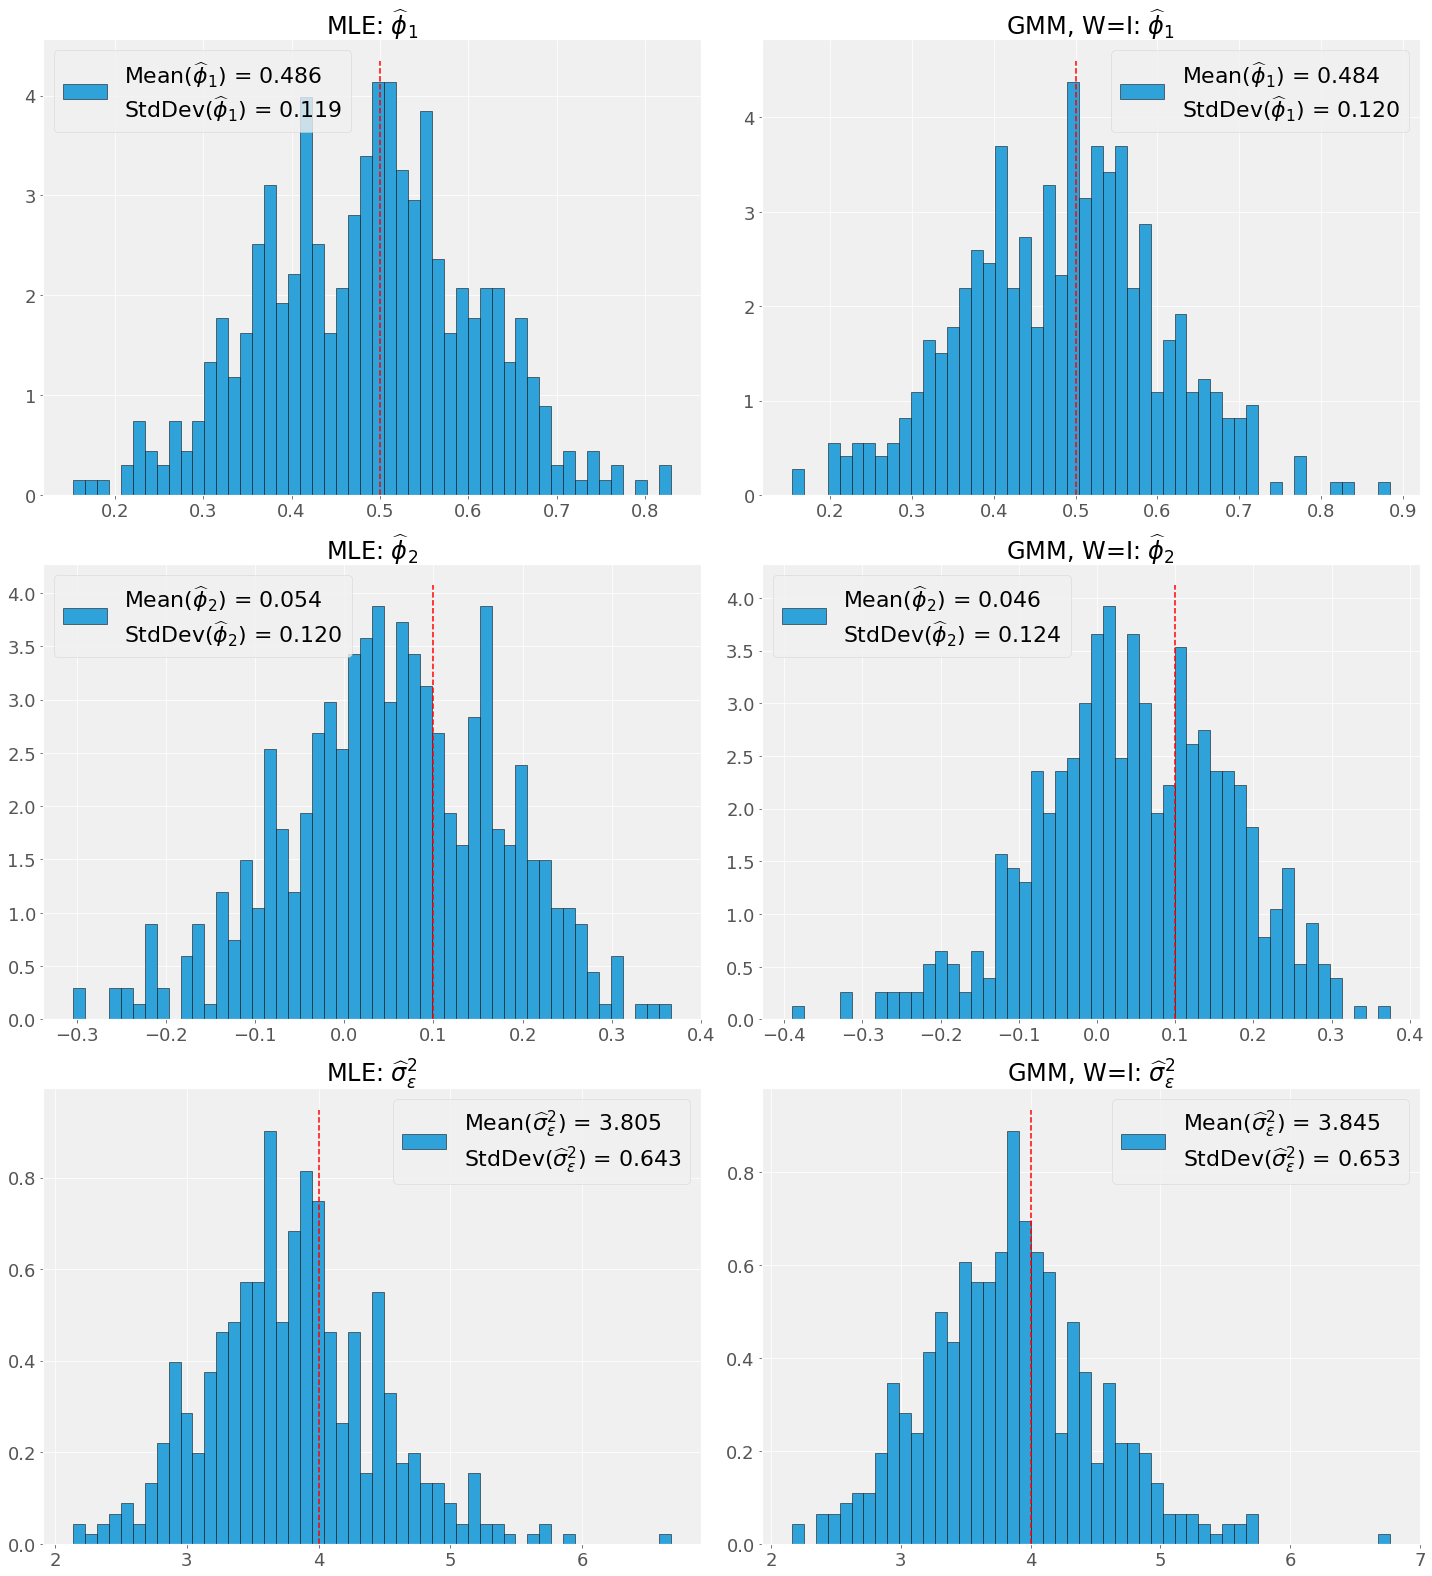

In [39]:
### MLE vs. GMM: AR(2)
phi1, phi2 = 0.5, 0.1
sigma = 2
nsample_T, nsims_N = 75, 500
np_dist_type, np_dist_params = 'normal', (0, sigma)
ydict_ar2 = {'ar_coeffs': [1, -phi1, -phi2], 'ma_coeffs': [1], 
             'nsample_T': nsample_T, 'nsims_N': nsims_N, 
             'np_dist_type': np_dist_type, 'np_dist_params': np_dist_params}

ysims3 = simulate_arma(ar_coefs=[1, -phi1, -phi2], ma_coefs=[1], nsample_T=nsample_T, nsims_N=nsims_N)

### Simulate 'nsims_N' paths with sample size 'nsample_T'
k_momconds_list=(2,3,4)
gmm_est = 'ar2_gmm_est_iter'
df_ar2_mle, df_ar2_gmm = simulate_arma_mle_vs_gmm(gmm_est=gmm_est, n_iter=0, k_momconds_list=k_momconds_list,
                                                  yprocess=ysims3, x0=None, p_order=2, q_order=0, 
                                                  summary=False, plot_sims=0)

#df_ar2_mle, df_ar2_gmm = simulate_arma_mle_vs_gmm(gmm_est=gmm_est, n_iter=0, k_momconds_list=k_momconds_list,
#                                                  yprocess=None, ydict=ydict_ar2, x0=None, p_order=2, q_order=0, 
#                                                  summary=False, plot_sims=0)


### Histogram of empirical estimates
fig = plot_ar2_mle_vs_gmm(df_ar2_mle, df_ar2_gmm, phi1=phi1, phi2=phi2, sigma2eps=sigma**2, 
                          gmm_est_str='GMM, W=I')
fig.tight_layout()  

Let's look at Monte Carlo statistics

In [40]:
### Extract coefficients:
phi1_mle = df_ar2_mle['arma_mle_coeffs'].apply(lambda x: x[0]).values
phi2_mle = df_ar2_mle['arma_mle_coeffs'].apply(lambda x: x[1]).values

phi1_gmm = df_ar2_gmm['arma_gmm_coeffs'].apply(lambda x: x[0]).values
phi2_gmm = df_ar2_gmm['arma_gmm_coeffs'].apply(lambda x: x[1]).values

In [41]:
### phi1
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=phi1_mle, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=phi1_gmm, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.486,0.119,0.153,0.224,0.298,0.335,0.402,0.495,0.561,0.640,0.676,0.759,0.829
GMM: T=75,500,0.484,0.121,0.153,0.211,0.286,0.329,0.401,0.490,0.558,0.641,0.682,0.778,0.884


In [42]:
### phi2
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=phi2_mle, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=phi2_gmm, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.054,0.120,-0.304,-0.239,-0.147,-0.101,-0.022,0.055,0.145,0.206,0.237,0.306,0.366
GMM: T=75,500,0.046,0.124,-0.391,-0.258,-0.163,-0.106,-0.030,0.044,0.134,0.205,0.243,0.294,0.374


In [43]:
### sigma2eps
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=np.array(df_ar2_mle['arma_mle_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=np.array(df_ar2_gmm['arma_gmm_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,3.805,0.644,2.135,2.450,2.819,2.993,3.379,3.787,4.202,4.596,4.905,5.458,6.676
GMM: T=75,500,3.845,0.653,2.159,2.443,2.873,3.004,3.421,3.828,4.210,4.677,4.954,5.613,6.769


Let's compare **MLE** estimates to a **GMM** estimation procedure that only uses the moment conditions:

$$
 E\left[\mathbf{h}(\mathbf{\beta}, \mathbf{z}_t)\right] \equiv \left[ 
 \begin{array}{c}
  \rho_1 - \phi_1 - \phi_2 \rho_1 \\
  \rho_2 - \phi_1 \rho_1  - \phi_2 \\
  \end{array}
  \right]
$$

to estimate $\phi_1$ and $\phi_2$, with $\sigma_{\epsilon}^2$ estimated given the other two. This boils down to Method of Moments (**MM**), hence there really is no need for a weight matrix $W$.

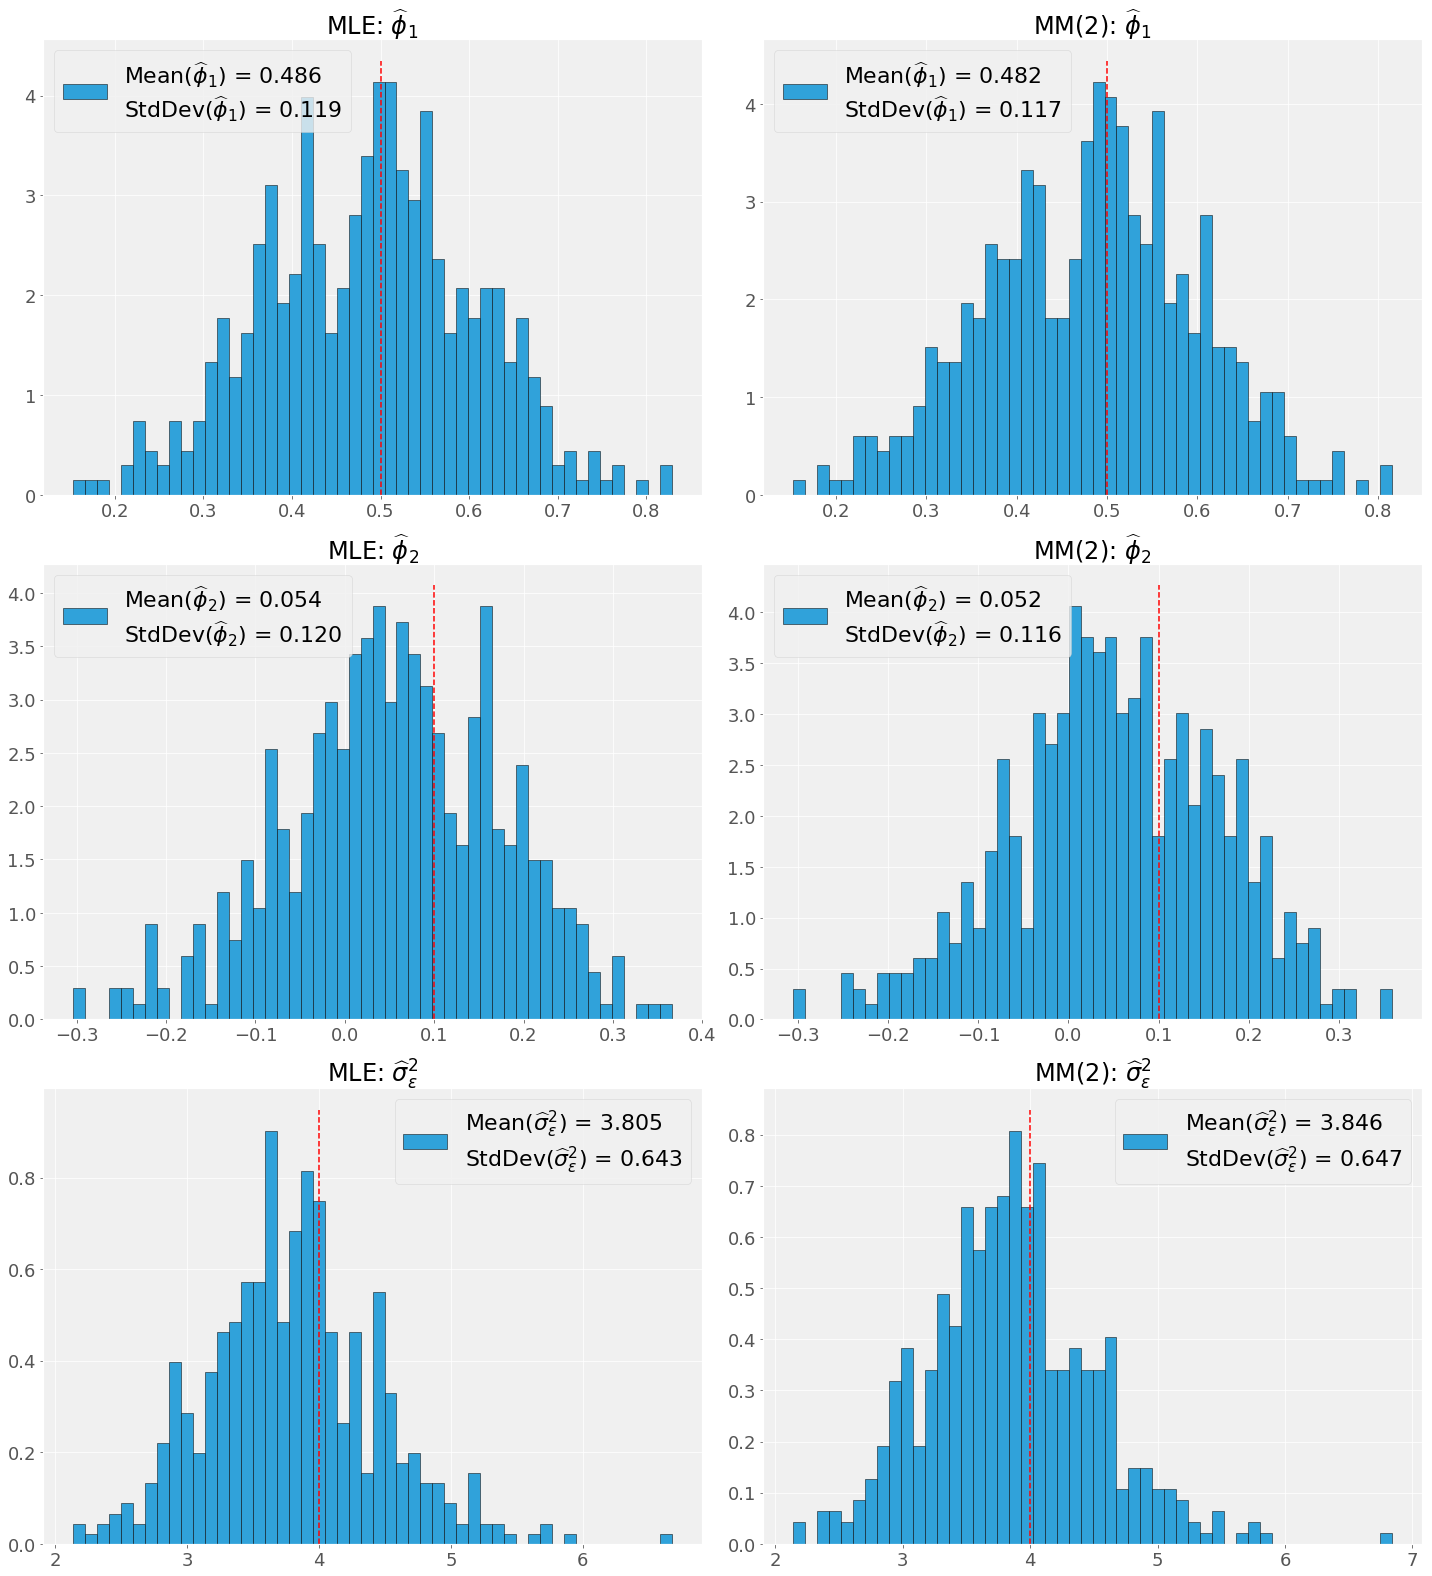

In [44]:
### Simulate 'nsims_N' paths with sample size 'nsample_T'
k_momconds_list=(2,3)
gmm_est = 'ar2_gmm_est_iter'
df_ar2_mle, df_ar2_mm = simulate_arma_mle_vs_gmm(gmm_est=gmm_est, n_iter=0, k_momconds_list=k_momconds_list,
                                                  yprocess=ysims3, x0=None, p_order=2, q_order=0, 
                                                  summary=False, plot_sims=0)

### Histogram of empirical estimates
fig = plot_ar2_mle_vs_gmm(df_ar2_mle, df_ar2_mm, phi1=phi1, phi2=phi2, sigma2eps=sigma**2, 
                         gmm_est_str='MM(2)')
fig.tight_layout()  

Let's look at Monte Carlo statistics once again:

In [45]:
### Extract coefficients:
phi1_mle = df_ar2_mle['arma_mle_coeffs'].apply(lambda x: x[0]).values
phi2_mle = df_ar2_mle['arma_mle_coeffs'].apply(lambda x: x[1]).values

phi1_mm = df_ar2_mm['arma_gmm_coeffs'].apply(lambda x: x[0]).values
phi2_mm = df_ar2_mm['arma_gmm_coeffs'].apply(lambda x: x[1]).values

In [46]:
### phi1
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=phi1_mle, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_mm = monte_carlo_stats(np_coef=phi1_mm, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_mm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.486,0.119,0.153,0.224,0.298,0.335,0.402,0.495,0.561,0.640,0.676,0.759,0.829
GMM: T=75,500,0.482,0.117,0.153,0.224,0.292,0.326,0.400,0.487,0.559,0.631,0.674,0.751,0.815


In [47]:
### phi2
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=phi2_mle, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_mm = monte_carlo_stats(np_coef=phi2_mm, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_mm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.054,0.120,-0.304,-0.239,-0.147,-0.101,-0.022,0.055,0.145,0.206,0.237,0.306,0.366
GMM: T=75,500,0.052,0.117,-0.306,-0.236,-0.145,-0.097,-0.021,0.050,0.140,0.199,0.234,0.299,0.359


In [48]:
### sigma2eps
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=np.array(df_ar2_mle['arma_mle_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_mm = monte_carlo_stats(np_coef=np.array(df_ar2_mm['arma_gmm_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_mm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,3.805,0.644,2.135,2.450,2.819,2.993,3.379,3.787,4.202,4.596,4.905,5.458,6.676
GMM: T=75,500,3.846,0.647,2.138,2.461,2.866,3.012,3.427,3.830,4.246,4.633,4.956,5.482,6.841


In the above **GMM** estimation, for the over-identified case (with 1 extra moment condition than needed), we used weighting matrix $W=I$. We could also try to use $W=S^{-1}$. 

However, you will see that $S$ will be close to singular, hence "optimal GMM" will be ill-posed. In cases like this, we always opt for $W=I$.

### Exercise 2: Part 4 (Digression)

Now, let's suppose that instead $\epsilon_t \overset{i.i.d.}{\sim} t(df=2)$  i.e. $\epsilon_t$ follows a student $t$ distribution with fat tails.

However, let's proceed and compare **MLE** and **GMM** estimates of $\phi_1$, $\phi_2$, and $\sigma_{\epsilon}^2$, where **MLE** still assumes the $\{\epsilon_t\}_{t\geq0}$ are Gaussian. 

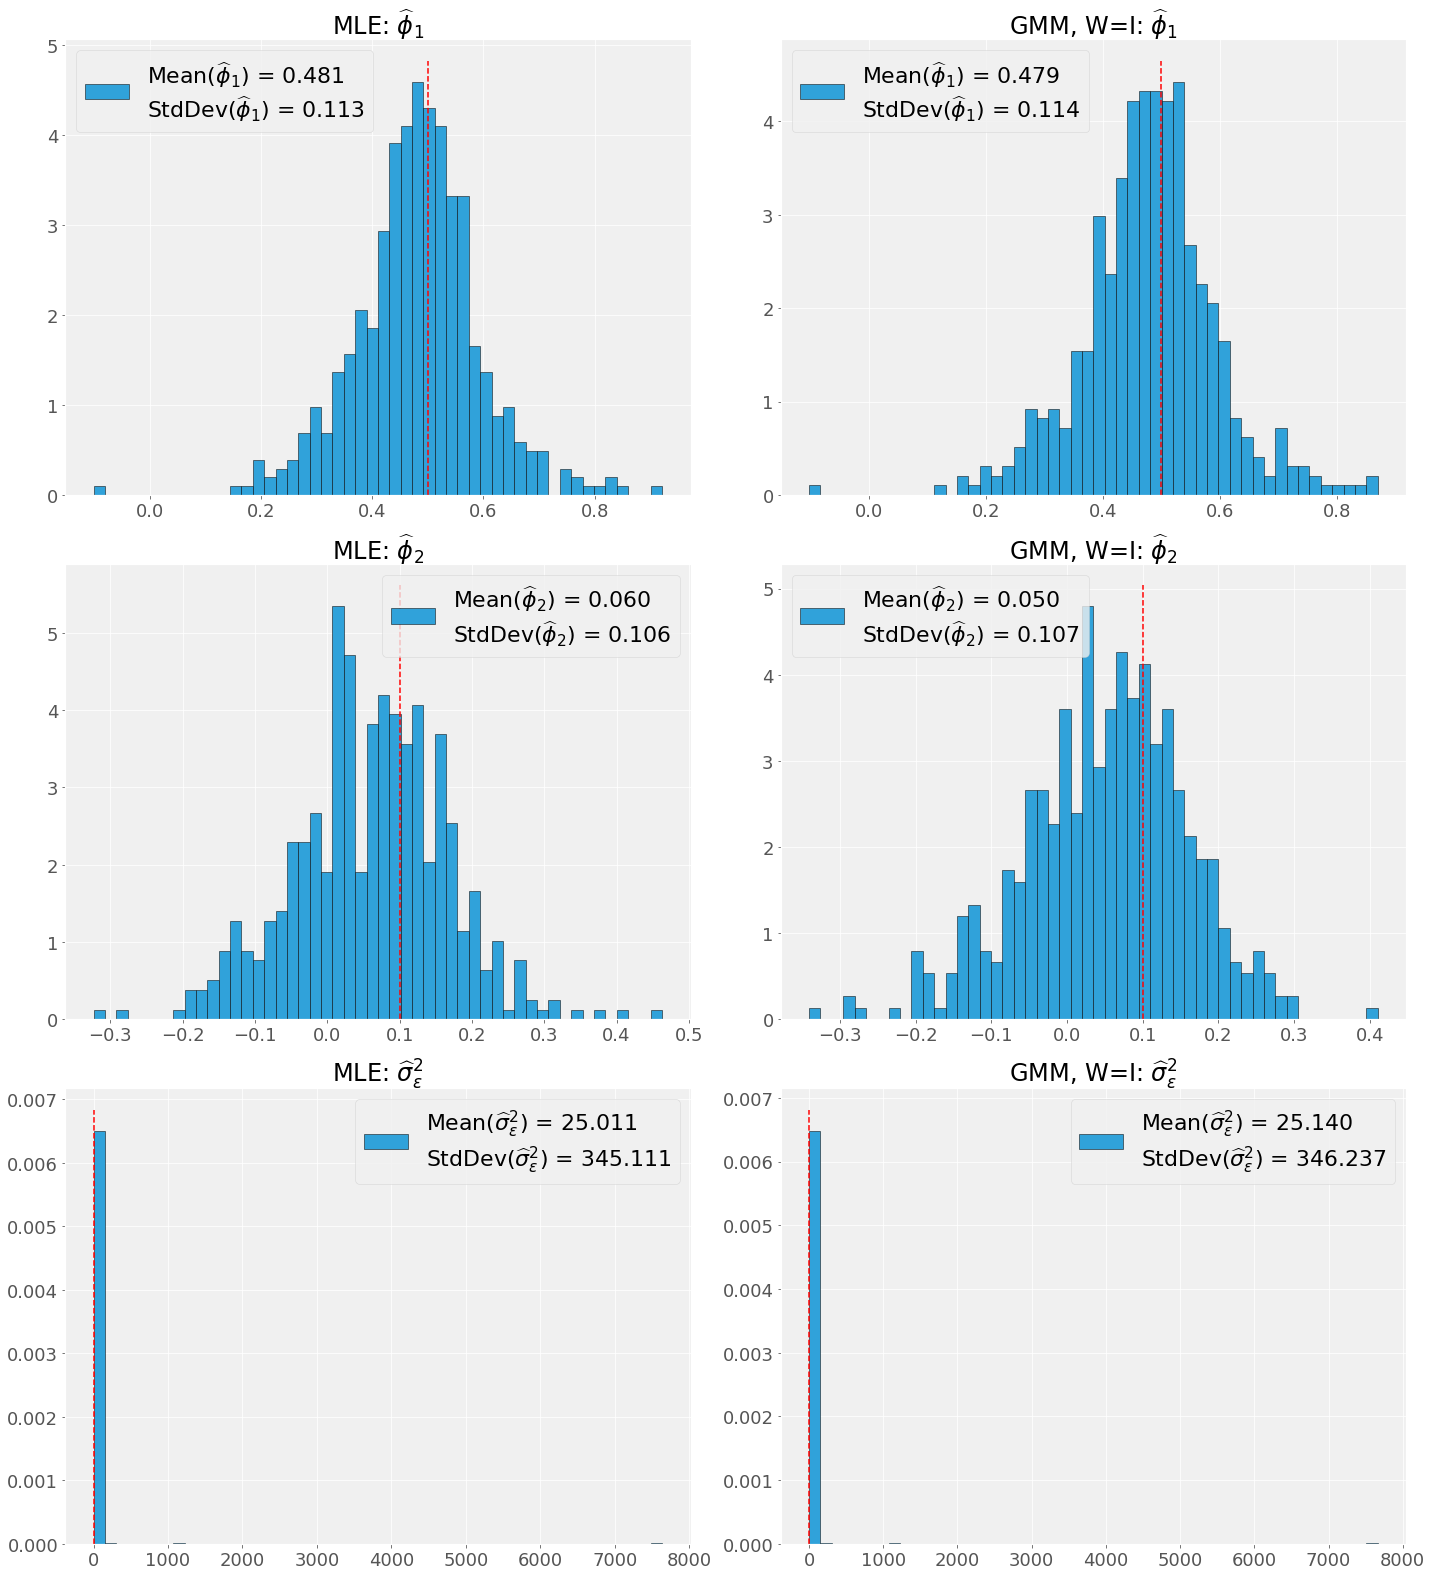

In [49]:
### MLE vs. GMM: AR(2) w/ student-t shocks
phi1, phi2 = 0.5, 0.1
df = 2
nsample_T, nsims_N = 75, 500
np_dist_type, np_dist_params = 'standard_t', df
ydict_ar2 = {'ar_coeffs': [1, -phi1, -phi2], 'ma_coeffs': [1], 
             'nsample_T': nsample_T, 'nsims_N': nsims_N, 
             'np_dist_type': np_dist_type, 'np_dist_params': np_dist_params}

ysims4 = simulate_arma(ar_coefs=[1, -phi1, -phi2], ma_coefs=[1], nsample_T=nsample_T, nsims_N=nsims_N)

### Simulate 'nsims_N' paths with sample size 'nsample_T'
k_momconds_list=(2,3,4)
gmm_est = 'ar2_gmm_est_iter'
df_ar2_mle_miss, df_ar2_gmm_miss = simulate_arma_mle_vs_gmm(gmm_est=gmm_est, n_iter=0, k_momconds_list=k_momconds_list,
                                                       yprocess=ysims4, x0=None, p_order=2, q_order=0, 
                                                       summary=False, plot_sims=0)

### Histogram of empirical estimates
fig = plot_ar2_mle_vs_gmm(df_ar2_mle_miss, df_ar2_gmm_miss, phi1=phi1, phi2=phi2, sigma2eps=sigma**2, 
                          gmm_est_str='GMM, W=I')
fig.tight_layout()  

In [50]:
### Extract coefficients:
phi1_mle_miss = df_ar2_mle_miss['arma_mle_coeffs'].apply(lambda x: x[0]).values
phi2_mle_miss = df_ar2_mle_miss['arma_mle_coeffs'].apply(lambda x: x[1]).values

phi1_gmm_miss = df_ar2_gmm_miss['arma_gmm_coeffs'].apply(lambda x: x[0]).values
phi2_gmm_miss = df_ar2_gmm_miss['arma_gmm_coeffs'].apply(lambda x: x[1]).values

In [51]:
### phi1
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=phi1_mle_miss, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=phi1_gmm_miss, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.481,0.113,-0.101,0.204,0.290,0.347,0.423,0.484,0.545,0.604,0.661,0.795,0.921
GMM: T=75,500,0.479,0.114,-0.102,0.201,0.285,0.342,0.416,0.481,0.539,0.606,0.661,0.773,0.870


In [52]:
### phi2
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=phi2_mle_miss, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=phi2_gmm_miss, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.060,0.106,-0.323,-0.182,-0.129,-0.077,-0.003,0.064,0.128,0.181,0.222,0.318,0.463
GMM: T=75,500,0.050,0.107,-0.341,-0.204,-0.138,-0.085,-0.014,0.058,0.121,0.178,0.212,0.269,0.410


In [53]:
### sigma2eps
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=np.array(df_ar2_mle_miss['arma_mle_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_gmm = monte_carlo_stats(np_coef=np.array(df_ar2_gmm_miss['arma_gmm_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,25.011,345.457,1.038,1.598,1.995,2.342,2.996,4.366,7.168,13.328,18.731,69.062,7636.562
GMM: T=75,500,25.140,346.584,1.033,1.632,2.070,2.373,3.044,4.462,7.209,13.392,18.761,69.061,7661.477


Let's compare **MLE** estimates to a **GMM** estimation procedure that only uses the moment conditions:

$$
 E\left[\mathbf{h}(\mathbf{\beta}, \mathbf{z}_t)\right] \equiv \left[ 
 \begin{array}{c}
  \rho_1 - \phi_1 - \phi_2 \rho_1 \\
  \rho_2 - \phi_1 \rho_1  - \phi_2 \\
  \end{array}
  \right]
$$

to estimate $\phi_1$ and $\phi_2$, with $\sigma_{\epsilon}^2$ estimated given the other two. 

As before, this boils down to Method of Moments (**MM**), hence there really is no need for a weight matrix $W$.

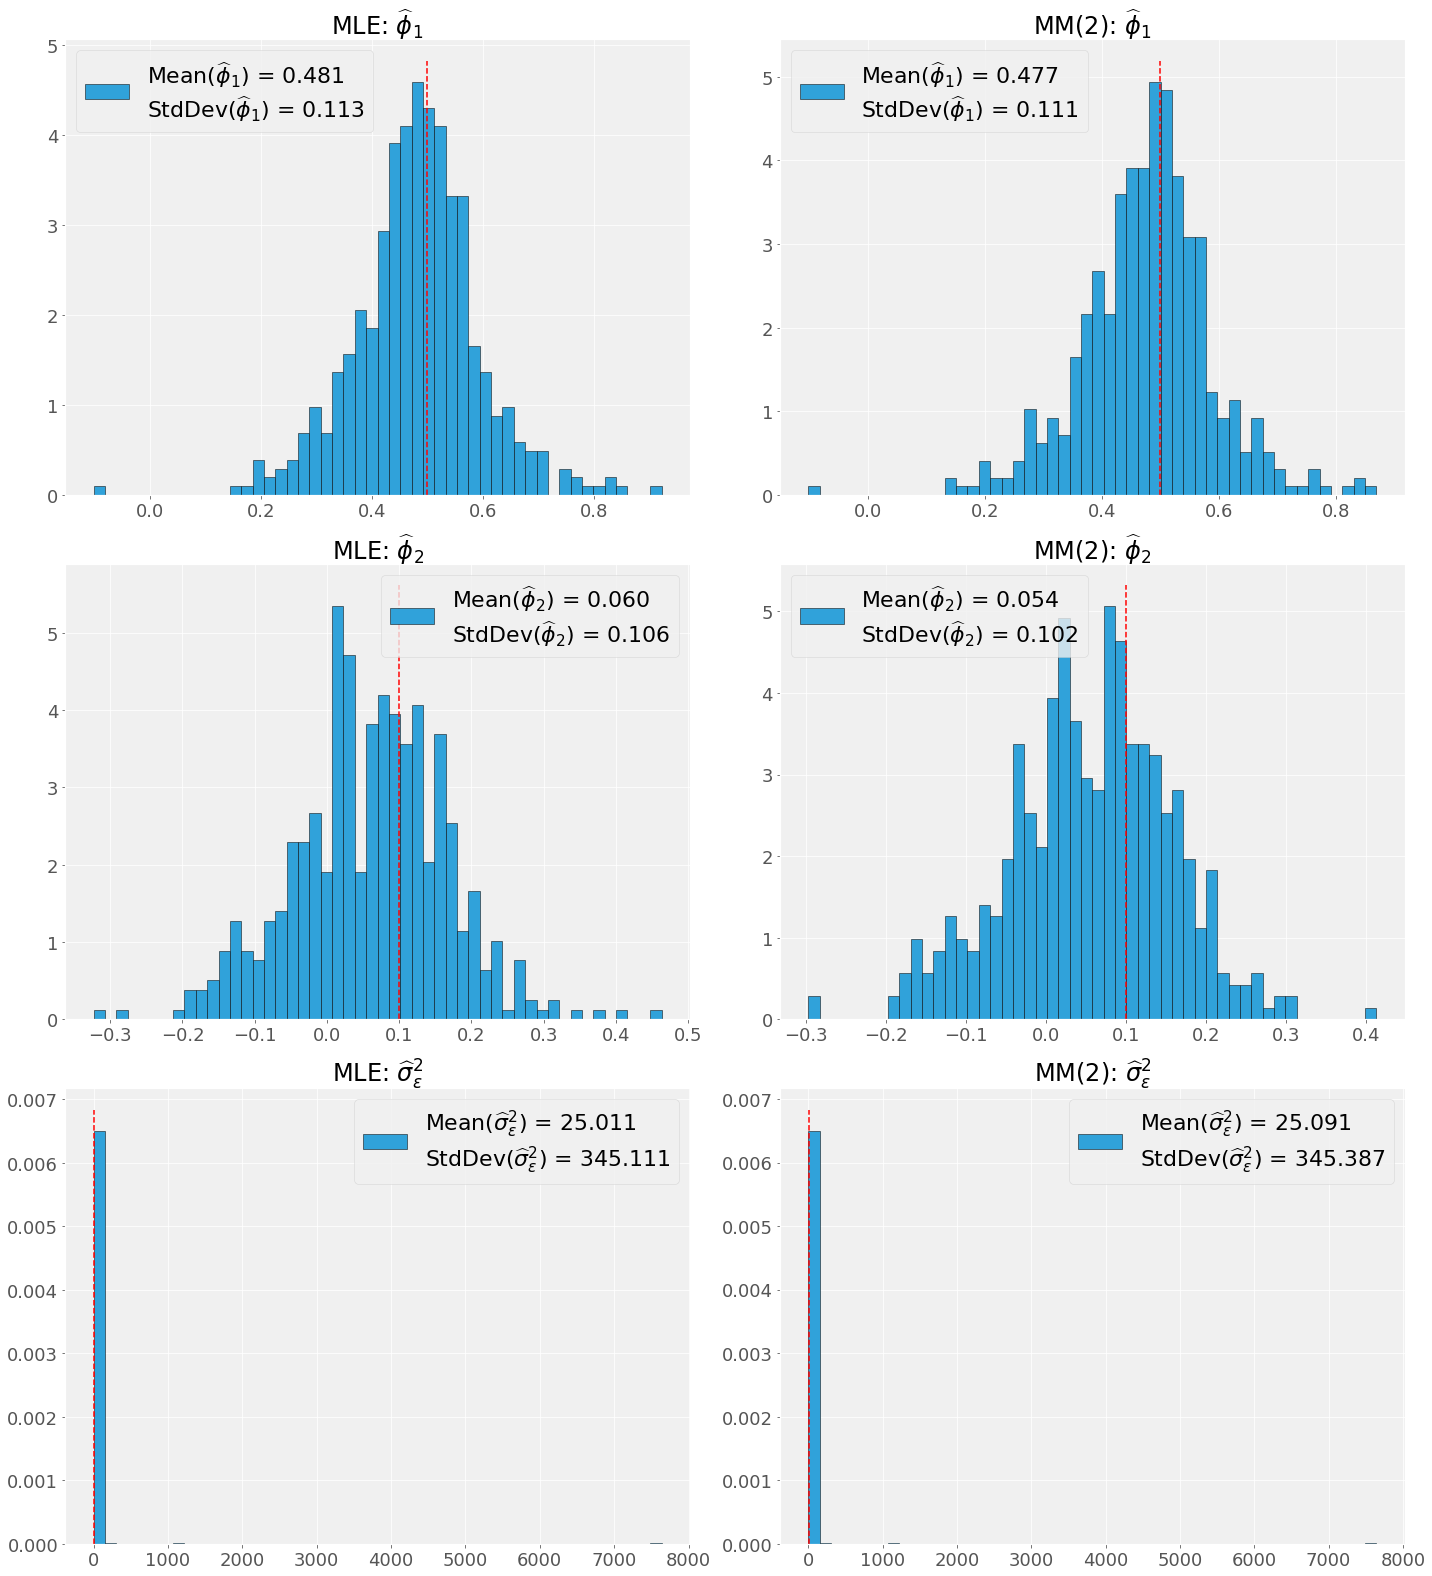

In [54]:
### Simulate 'nsims_N' paths with sample size 'nsample_T'
k_momconds_list=(2,3)
gmm_est = 'ar2_gmm_est_iter'
df_ar2_mle_miss, df_ar2_mm_miss = simulate_arma_mle_vs_gmm(gmm_est=gmm_est, n_iter=0, k_momconds_list=k_momconds_list,
                                                  yprocess=ysims4, x0=None, p_order=2, q_order=0, 
                                                  summary=False, plot_sims=0)

### Histogram of empirical estimates
fig = plot_ar2_mle_vs_gmm(df_ar2_mle_miss, df_ar2_mm_miss, phi1=phi1, phi2=phi2, sigma2eps=sigma**2, 
                         gmm_est_str='MM(2)')
fig.tight_layout()  

In [55]:
### Extract coefficients:
phi1_mle_miss = df_ar2_mle_miss['arma_mle_coeffs'].apply(lambda x: x[0]).values
phi2_mle_miss = df_ar2_mle_miss['arma_mle_coeffs'].apply(lambda x: x[1]).values

phi1_mm_miss = df_ar2_mm_miss['arma_gmm_coeffs'].apply(lambda x: x[0]).values
phi2_mm_miss = df_ar2_mm_miss['arma_gmm_coeffs'].apply(lambda x: x[1]).values

In [56]:
### phi1
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=phi1_mle_miss, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_mm = monte_carlo_stats(np_coef=phi1_mm_miss, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_mm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.481,0.113,-0.101,0.204,0.290,0.347,0.423,0.484,0.545,0.604,0.661,0.795,0.921
GMM: T=75,500,0.477,0.111,-0.102,0.192,0.285,0.348,0.416,0.483,0.538,0.599,0.658,0.762,0.870


In [57]:
### phi2
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=phi2_mle_miss, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_mm = monte_carlo_stats(np_coef=phi2_mm_miss, nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_gmm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,0.060,0.106,-0.323,-0.182,-0.129,-0.077,-0.003,0.064,0.128,0.181,0.222,0.318,0.463
GMM: T=75,500,25.140,346.584,1.033,1.632,2.070,2.373,3.044,4.462,7.209,13.392,18.761,69.061,7661.477


In [58]:
### sigma2eps
percentiles = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
mc_stats_mle = monte_carlo_stats(np_coef=np.array(df_ar2_mle_miss['arma_mle_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='MLE').T
mc_stats_mm = monte_carlo_stats(np_coef=np.array(df_ar2_mm_miss['arma_gmm_sigma2eps'].tolist()), nsample=nsample_T, 
                                 percentiles=percentiles, estimator='GMM').T
mc_stats = mc_stats_mle.append(mc_stats_mm)
mc_stats

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
MLE: T=75,500,25.011,345.457,1.038,1.598,1.995,2.342,2.996,4.366,7.168,13.328,18.731,69.062,7636.562
GMM: T=75,500,25.091,345.733,1.040,1.603,2.047,2.369,3.036,4.411,7.191,13.349,18.734,69.136,7642.676


## (Optional) Example 3: GMM vs MLE: Chi-squared distribution

Suppose $y_t$ is *i.i.d.* with $\chi^2$ distribution $\chi^2(\theta)$. Let's compare **MLE** and various **GMM** estimates of $\hat{\theta}$.

### Moments
The (non-central) moments are given by
$$
m_k(\theta) = 2^k \frac{ \Gamma(k + \theta/2 ) }{ \Gamma(\theta/2) }
$$
For example, the first 4 moments are: 
* $k=1$: $m_{1}(k)=k$
* $k=2$: $m_{2}(k)=k(k + 2)$
* $k=3$: $m_{3}(k)=k(k + 2)(k + 4)$
* $k=4$: $m_{4}(k)=k(k + 2)(k + 4)(k + 6)$

The following cell blocks provide functions for computing the various theoretical and sample moments of the $\chi^2$ distribution, computing the **MLE** and **GMM** estimates; and wrappers for repeated simulation and estimation of the various estimates.


### Exercises:
* Compare the **MLE** and **GMM** estimates for different sample sizes and $\theta$
* Experiment with different sets of moment conditions

In [59]:
def chi2_mk(theta, k):
    """theoretical k-th (uncentered) moment"""
    mk = 2**k * (scipy.special.gamma(k + theta/2)/scipy.special.gamma(theta/2))
    return mk

def chi2_momconds(y, theta, k_mom_list=(1,2) ):
    """stacked moment conditions"""
    Nobs = y.shape[0]
    k_moms = len(k_mom_list)
    g = np.zeros( (Nobs, k_moms) )
    for idx, k in enumerate(k_mom_list):
        g[:, idx] = y**k - chi2_mk(theta, k)
    return g

def chi2_S_gmm(y, theta, k_mom_list=(1,2) ):
    """S matrix"""
    Nobs = y.shape[0]
    g = chi2_momconds(y, theta, k_mom_list=k_mom_list)
    S = np.dot(g.T, g)/Nobs
    return S

def chi2_S0_gmm( theta ):
    """theoretical S matrix (first two moment conditions)"""
    m1 = chi2_mk(theta, 1)
    m2 = chi2_mk(theta, 2)
    m3 = chi2_mk(theta, 3)
    m4 = chi2_mk(theta, 4)
    S11 = m2 - m1**2 # = 2*theta
    S12 = m3 - m1*m2 # = 4*theta*(theta + 2)
    S22 = m4 - m2**2 # = 8*theta*(theta + 2)*(theta + 3)
    S = np.array([[S11, S12], [S12, S22]])
    return S

def chi2_gmm_objfunc(y, theta, S=None, k_mom_list=(1,2) ):
    """GMM objective function"""
    k_moms = len(k_mom_list)
    if S is None:
        S = np.eye(k_moms)
    g = chi2_momconds(y, theta, k_mom_list=k_mom_list)
    g_mean = g.mean(axis=0)
    W = np.linalg.inv(S)
    gtWg = np.dot(np.dot(g_mean.T, W), g_mean)
    return gtWg


def chi2_logL(y, theta):
    """log-likelihood"""
    return np.sum(np.log(scipy.stats.chi2.pdf(y, theta)))

def chi2_mle(y):
    """scalar minimization of (negative) log-likelihood"""
    f = lambda x : -chi2_logL(y, x)
    res = scipy.optimize.minimize_scalar(f )
    theta_hat = res.x
    return theta_hat

def chi2_calc_gmm(y, S=None, k_mom_list=(1,2) ):
    """GMM estimate"""
    ### scalar minimization of quadratic form
    f = lambda x : chi2_gmm_objfunc(y, x, S=S, k_mom_list=k_mom_list)
    res = scipy.optimize.minimize_scalar(f)
    theta_hat = res.x
    return theta_hat

def chi2_calc_gmm_iter(y, n_iter, S0=None, k_mom_list=(1,2) ):
    """iterated GMM estimate (n_iter=0: no iteration)"""
    S = S0
    for n in range(n_iter+1):
        theta_hat = chi2_calc_gmm(y, S=S, k_mom_list=k_mom_list)
        S = chi2_S_gmm(y, theta_hat, k_mom_list=k_mom_list)
    return theta_hat


In [60]:
def sim_gmm_chi2(theta, nsample, Nsim=500, k_mom_list=(1,2) ):
    """Simulate and estimate GMM estimates of chi-2 param"""
    ### store estimates
    theta_hat = np.zeros( (Nsim, 8))
    for ss in range(Nsim):
        ### simulate
        np.random.seed(ss)
        ysim = np.random.chisquare(theta, size=nsample)
        
        ### MLE
        theta_hat[ss,0] = chi2_mle(ysim)
        
        ### MM (first moment only)
        theta_hat[ss,1] = chi2_calc_gmm_iter(ysim, 0, k_mom_list=(1,))
        
        ### MM (second moment only)
        theta_hat[ss,2] = chi2_calc_gmm_iter(ysim, 0, k_mom_list=(2,))
        
        ### GMM with W=I
        theta_hat[ss,3] = chi2_calc_gmm_iter(ysim, 0, k_mom_list=k_mom_list)
        
        ### GMM with known S (first two moments)
        S0 = chi2_S0_gmm(theta)
        theta_hat[ss,4] = chi2_calc_gmm_iter(ysim, 0, S0=S0, k_mom_list=k_mom_list)
        
        ### iterated GMM
        theta_hat[ss,5] = chi2_calc_gmm_iter(ysim, 1, k_mom_list=k_mom_list)
        theta_hat[ss,6] = chi2_calc_gmm_iter(ysim, 2, k_mom_list=k_mom_list)
        theta_hat[ss,7] = chi2_calc_gmm_iter(ysim, 3, k_mom_list=k_mom_list)
    return theta_hat


def compare_gmm_chi2(theta_hat):
    """
    Post estimation comparison of GMM estimates
    """
    Nsim, Nest = theta_hat.shape
    est_names = ('MLE', 'MM(1)', 'MM(2)', 'GMM, W=I', r'GMM(2), S from $\theta$ known',
                'Iterated(1) GMM', 'Iterated(2) GMM', 'Iterated(3) GMM')
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,12))
    for n,(r,c) in enumerate(itertools.product(range(2),range(4))):
        print('%s estimates:' % est_names[n])
        print('\tMean: %.03f' % np.mean(theta_hat[:,n]))
        print('\tMedian: %.03f' % np.median(theta_hat[:,n]))
        print('\tStd Dev: %.03f' % np.std(theta_hat[:,n]), '\n')
        
        ### histogram
        axes[r, c].hist(theta_hat[:,n], bins=50, range=[0,5], density=True, edgecolor = "black")
        axes[r, c].set_title(est_names[n], size=18)
    return fig
    

In [61]:
### Simulate and estimate parameter for Chi-Squared(theta) using MLE/GMM w/ true theta=3, n=100
theta = 3
nsample = 100
theta_hat = sim_gmm_chi2(theta, nsample, Nsim=500, k_mom_list=(1,2))

MLE estimates:
	Mean: 3.017
	Median: 3.010
	Std Dev: 0.202 

MM(1) estimates:
	Mean: 3.004
	Median: 3.006
	Std Dev: 0.247 

MM(2) estimates:
	Mean: 2.986
	Median: 2.990
	Std Dev: 0.337 

GMM, W=I estimates:
	Mean: 2.987
	Median: 2.990
	Std Dev: 0.335 

GMM(2), S from $\theta$ known estimates:
	Mean: 3.012
	Median: 3.008
	Std Dev: 0.221 

Iterated(1) GMM estimates:
	Mean: 2.979
	Median: 2.981
	Std Dev: 0.228 

Iterated(2) GMM estimates:
	Mean: 2.980
	Median: 2.983
	Std Dev: 0.226 

Iterated(3) GMM estimates:
	Mean: 2.980
	Median: 2.984
	Std Dev: 0.226 



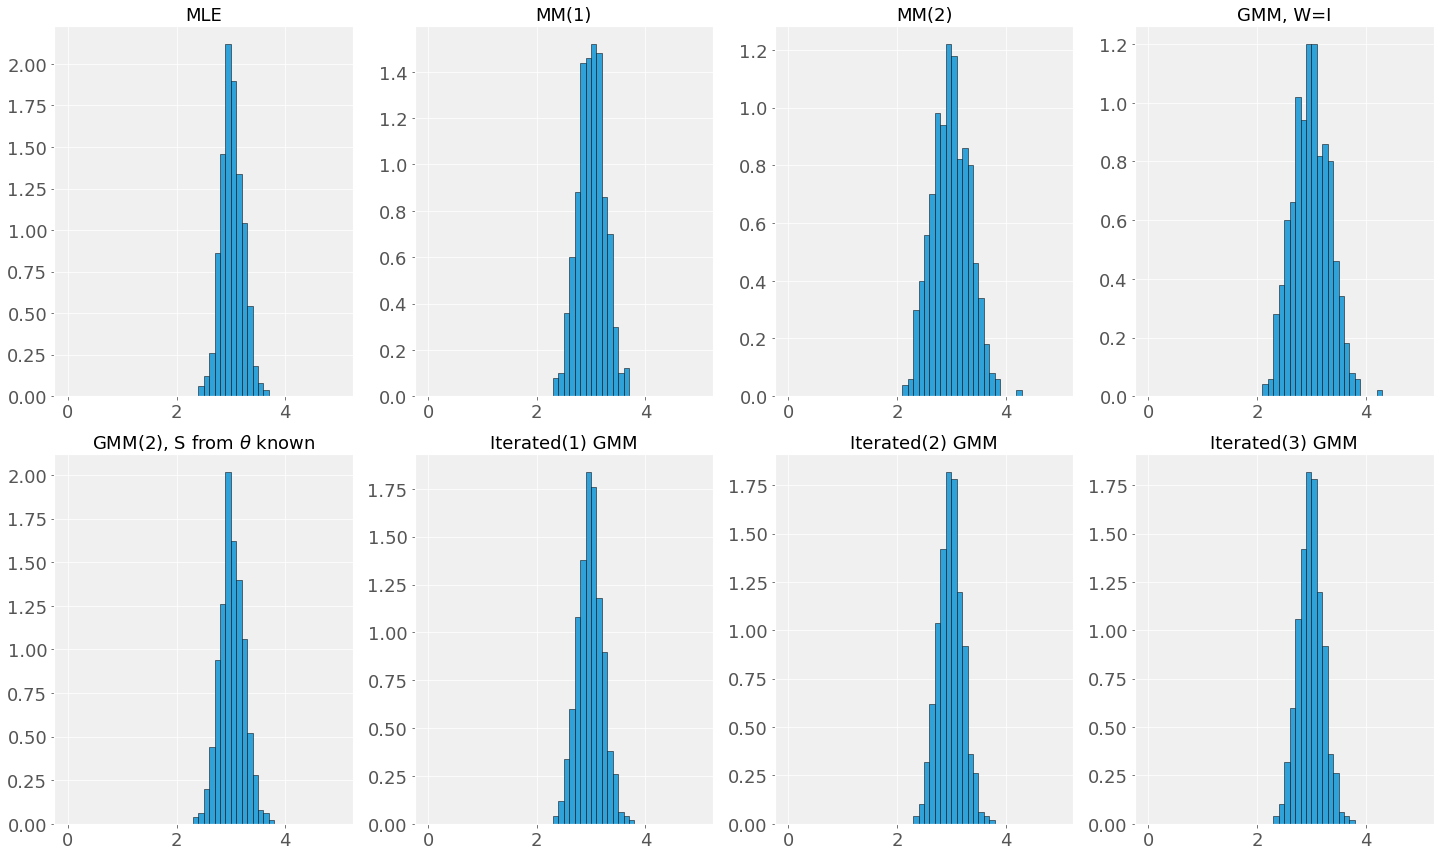

In [62]:
fig = compare_gmm_chi2(theta_hat)
fig.tight_layout()

## Consumption Capital Asset Pricing Model (CCAPM)

Recall from **Lecture 4** the CCAPM and the moment conditions implied by the model:
$$\text{E}   \left[ \mathbf{h}\left( \mathbf{\theta ,z}_{t}\right) \right] = 0$$
$$\mathbf{h}\left( \mathbf{\theta ,z}_{t}\right) = (h_1(\theta ,\mathbf{z}_{t}),..., h_J(\theta ,\mathbf{z}_{t}))'$$   
$$h_j(\theta , \mathbf{z}_{t}) = \beta\left(\frac{C_{t+1}}{C_{t}}\right)^{-\gamma} R_{j,t+1} - 1$$
$$\mathbf z_t = \left(R_{1,t}, ...,R_{J,t}, C_{t}\right)'$$
where $\theta = (\beta, \gamma)'$, $R_{j,t+1}=(P_{j,t+1}+D_{j,t+1})/P_{j,t}$ are returns for $j=1,...,J$ assets, and $C_t$ is a measure of aggregate consumption. 

There are $J$ moment conditions (one for each asset) and 2 parameters. 
The GMM estimator picks $\theta = (\beta, \gamma)'$ to make the objective function 

$$\widehat{Q} = \left[ \mathbf{g}(\widehat{\mathbf{\theta}}; \mathbf{Z}_{T})\right]' \widehat{\mathbf{S}}^{-1}
    \left[ \mathbf{g}(\widehat{\mathbf{\theta}}; \mathbf{Z}_{T})\right]$$
as small as possible, where $\mathbf{S}$ is the estimate of the **spectral density matrix**:

$$\widehat{\mathbf{S}} =\sum_{j=-\infty }^{\infty} 
    \frac{1}{T}\sum_{t=1}^{T}
    \left[ \mathbf{h}\left( \mathbf{%
        \theta }\mathbf{,z}_{t}\right) \right]
    \left[ \mathbf{h}\left( \mathbf{\theta }\mathbf{,z}_{t-j}\right) \right] ^{\prime}$$

and $$ \mathbf{g}(\widehat{\mathbf{\theta}}; \mathbf{Z}_{T})  \equiv\frac{1}{T} \sum_{t=1}^{T}\mathbf{h}\left( \widehat{\mathbf{\theta}}, \mathbf{z}_{t}\right)$$


We will now implement GMM using Python's `statsmodels` GMM estimation routine. If you don't have this package, make sure to install it (run `!pip install statsmodels` in your notebook).

### Statsmodels GMM 

The following is based on https://github.com/josef-pkt/misc/blob/master/notebooks/ex_gmm_gamma.ipynb:

To use `statsmodels` GMM estimation, create a GMM **subclass** `CCAPM_GMM` that defines a function `momcond` (the moment conditions). This is a function of the parameters, and will reference the GMM attributes `endog`, `exog`, and `instrument`.

For the CCAPM example, the parameters are $\delta, \gamma$. The data is the consumption ratio $C_t / C_{t-1}$ ($T \times 1$ vector) and returns $\mathbf{R}_t$ ($T \times K$ matrix).  `CCAPM_GMM` takes these two inputs and initializes the GMM object with the correct number of parameters and moment conditions.

Note that `GMM` requires arguments `endog`, `exog`, and `instrument` even if some of these arguments are not used by the moment condition.

After the model is set up, `fit()` estimates the model (intial parameters required).

`maxiter=0` or `maxiter=1` returns the 1-step GMM estimator with identity weighting matrix, while `maxiter=n` computes iterated GMM. The continuously updated GMM estimator is also available as `maxiter='cue'`. Different intial (inverse) weighting matrices can be specified using `inv_weights`. `weights_method` allows for different methods of computing the weighting matrix, although based on the documentation, these options don't seem to be complete yet.

Let's load in the data from files `PCE_q.csv`, `FF_factors_q.csv`, `'FF_portfolios_q.csv`:
* `PCE_q.csv` contains quarterly data on U.S. aggregate consumption
* `FF_factors_q.csv` contains the quarterly Fama-French (1993) factors, which are portfolio returns
* `FF_portfolios_q.csv` contains the quarterly Fama-French (1993) 3 x 2 sorted portfolio returns, used to   construct the factor returns in `FF_factors_q.csv`.

In [68]:
### Load data required in the estimation of the CCAPM: data is quarterly.

### Personal consumption expenditures (PCE): aggregate consumption measure
df_pce_q = pd.read_csv('PCE_q.csv')
df_pce_q['DATE'] = pd.to_datetime(df_pce_q['DATE'])
df_pce_q.set_index('DATE', inplace=True)

### Fama-French factors (% to decimals)
df_FF_q = pd.read_csv('FF_factors_q.csv')
df_FF_q['Date'] = pd.to_datetime(df_FF_q['Date'])
df_FF_q.set_index('Date', inplace=True)
df_FF_q = df_FF_q/100

### Fama-French portfolio returns (% to decimals)
df_FF6_q = pd.read_csv('FF_portfolios_q.csv')
df_FF6_q['Date'] = pd.to_datetime(df_FF6_q['Date'])
df_FF6_q.set_index('Date', inplace=True)
df_FF6_q = df_FF6_q/100

print(df_pce_q.head(), '\n')
print(df_pce_q.info(), '\n\n')

print(df_FF_q.head() , '\n')
print(df_FF_q.info() , '\n\n')

print(df_FF6_q.head() , '\n')
print(df_FF6_q.info(), '\n')

              PCEC    PCND   PCESV  PCNDSV
DATE                                      
1959-01-01 309.900 126.100 140.100 266.200
1959-04-01 315.900 127.200 143.300 270.500
1959-07-01 321.100 128.200 146.600 274.800
1959-10-01 323.200 129.500 149.600 279.100
1960-01-01 326.700 129.600 151.700 281.300 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 1959-01-01 to 2016-10-01
Data columns (total 4 columns):
PCEC      232 non-null float64
PCND      232 non-null float64
PCESV     232 non-null float64
PCNDSV    232 non-null float64
dtypes: float64(4)
memory usage: 9.1 KB
None 


            Rm-Rf    SMB    HML    RF
Date                                 
1959-03-01  0.020  0.064  0.035 0.006
1959-06-01  0.053 -0.020  0.019 0.007
1959-09-01 -0.032 -0.014  0.009 0.008
1959-12-01  0.054  0.023 -0.058 0.009
1960-03-01 -0.075  0.020 -0.019 0.010 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 232 entries, 1959-03-01 to 2016-12-01
Data columns (total 4 columns):
Rm-Rf    23

In [72]:
### Combine all of our (quarterly) data into one big dataframe indexed by quarterly dates.
df_pce_q.index = df_pce_q.index.astype('period[Q]')
df_FF_q.index  = df_FF_q.index.astype('period[Q]')
df_FF6_q.index = df_FF6_q.index.astype('period[Q]')

### Merge all 3 dataframes by index
if 'df_alldata' in locals():
    del(df_alldata)
else:    
    df_alldata = pd.merge(df_pce_q, df_FF_q, left_index=True, right_index=True)
    df_alldata = pd.merge(df_alldata, df_FF6_q, left_index=True, right_index=True)
    print(df_alldata.head()) 

          PCEC    PCND   PCESV  PCNDSV  Rm-Rf    SMB    HML    RF    B/L  \
DATE                                                                       
1959Q1 309.900 126.100 140.100 266.200  0.020  0.064  0.035 0.006  0.006   
1959Q2 315.900 127.200 143.300 270.500  0.053 -0.020  0.019 0.007  0.072   
1959Q3 321.100 128.200 146.600 274.800 -0.032 -0.014  0.009 0.008 -0.025   
1959Q4 323.200 129.500 149.600 279.100  0.054  0.023 -0.058 0.009  0.077   
1960Q1 326.700 129.600 151.700 281.300 -0.075  0.020 -0.019 0.010 -0.079   

          B/M    B/H    S/L    S/M    S/H  
DATE                                       
1959Q1  0.041  0.069  0.095  0.108  0.104  
1959Q2  0.034  0.100  0.047  0.041  0.058  
1959Q3 -0.021 -0.030 -0.053 -0.033 -0.031  
1959Q4  0.041  0.042  0.118  0.073  0.038  
1960Q1 -0.032 -0.115 -0.061 -0.042 -0.062  


We will use "real per capita consumption of non-durables and services" from the **Bureau of Economic Analysis (BEA)** as our measure of aggregate consumption. 

We also compute <u>gross</u> asset returns.

In [73]:
### aggregate consumption measure
c_var = 'PCNDSV'

df_alldata.insert(df_alldata.columns.get_loc('B/L'), 'R_mkt_rate', df_alldata['RF'] + df_alldata['Rm-Rf'])
df_alldata.insert(df_alldata.columns.get_loc('Rm-Rf'), 'c_growth', df_alldata[c_var]/df_alldata[c_var].shift(1))
df_alldata = df_alldata.dropna() # drop missings
print(df_alldata.head(), '\n')

### Gross returns: check they look ok. 
gross_R_mkt = 1 + df_alldata[['RF', 'R_mkt_rate']]
gross_R_mkt_ff6 = 1 + df_alldata[['RF', 'R_mkt_rate', 'B/L', 'B/M', 'B/H', 'S/L', 'S/M', 'S/H']]
print('Test assets (gross returns), Set 1: \n', gross_R_mkt.head(), '\n')
print('Test assets (gross returns), Set 2: \n', gross_R_mkt_ff6.head(), '\n')

### Number of time periods (observations):
Nobs = df_alldata.shape[0]
print('Number of time periods (observations) = ', Nobs)

          PCEC    PCND   PCESV  PCNDSV  c_growth  Rm-Rf    SMB    HML    RF  \
DATE                                                                          
1959Q2 315.900 127.200 143.300 270.500     1.016  0.053 -0.020  0.019 0.007   
1959Q3 321.100 128.200 146.600 274.800     1.016 -0.032 -0.014  0.009 0.008   
1959Q4 323.200 129.500 149.600 279.100     1.016  0.054  0.023 -0.058 0.009   
1960Q1 326.700 129.600 151.700 281.300     1.008 -0.075  0.020 -0.019 0.010   
1960Q2 332.600 132.000 154.200 286.200     1.017  0.033  0.014 -0.065 0.007   

        R_mkt_rate    B/L    B/M    B/H    S/L    S/M    S/H  
DATE                                                          
1959Q2       0.060  0.072  0.034  0.100  0.047  0.041  0.058  
1959Q3      -0.025 -0.025 -0.021 -0.030 -0.053 -0.033 -0.031  
1959Q4       0.063  0.077  0.041  0.042  0.118  0.073  0.038  
1960Q1      -0.065 -0.079 -0.032 -0.115 -0.061 -0.042 -0.062  
1960Q2       0.040  0.055  0.019 -0.010  0.077  0.017  0.012   

Tes

Let's calculate some descriptive statistics:

In [74]:
### Get time-series averages 
print('Market Return (mean): ', df_alldata['R_mkt_rate'].mean()*100, '%')
print('Market Return (st. dev): ', df_alldata['R_mkt_rate'].std()*100, '%', '\n')

print('Risk-free rate (mean): ', df_alldata['RF'].mean()*100, '%')
print('Risk-free rate (st. dev): ', df_alldata['RF'].std()*100, '%', '\n')

print('Equity Premium (mean): ', df_alldata['Rm-Rf'].mean()*100, '%')
print('Equity Premium (st. dev): ', df_alldata['Rm-Rf'].std()*100, '%', '\n')
print()

print('Sharpe Ratio = ', df_alldata['Rm-Rf'].mean()/df_alldata['Rm-Rf'].std())

Market Return (mean):  2.792531951463636 %
Market Return (st. dev):  8.353359465540782 % 

Risk-free rate (mean):  1.1450860640177492 %
Risk-free rate (st. dev):  0.7727853188243834 % 

Equity Premium (mean):  1.647445887445887 %
Equity Premium (st. dev):  8.402917400489567 % 


Sharpe Ratio =  0.19605641813757496


Now we set up our **GMM** estimation with some user-defined functions

In [75]:
### Set up GMM...
def get_sdf(c_growth, beta, gamma):
    """calculate SDF"""
    M = beta * (c_growth**-gamma)
    return M

def get_momcond(c_growth, r, beta, gamma):
    """moment condition"""
    M = get_sdf(c_growth, beta, gamma)
    g = M[:,None]*(1 + r) - 1
    return g

def get_S_mat(c_growth, r, beta, gamma):
    """get the S matrix, which will be used to construct weighting matrix W as W = S^-1"""
    g = get_momcond(c_growth, r, beta, gamma)
    Nobs = g.shape[0]
    S = np.dot(g.T, g)/Nobs
    return S

class CCAPM_GMM(GMM):
    def __init__(self, c_growth, r, **kwds):
        """
        Inputs:
            c_growth: C_{t}/C_{t-1} (T x 1)
            r: matrix of (net) returns (T x k_moms)
        """
        ### set appropriate counts for moment conditions and parameters
        k_moms = r.shape[1]
        kwds.setdefault('k_moms', k_moms)
        kwds.setdefault('k_params', 2)
    
        ### GMM class requires endog, exog, and instrument. exog not used
        exog = np.ones_like(r)
        super(CCAPM_GMM, self).__init__(endog=c_growth, exog=exog, instrument=r, **kwds)
    
    def momcond(self, params):
        beta, gamma = params
        ### "endog": consumption ratio
        c_growth = self.endog
        ### "instrument": returns
        r = self.instrument
        ### moment conditions
        g = get_momcond(c_growth, r, beta, gamma)     
        return g

### Quadratic objective function implied by GMM 
def get_objfunc(c_growth, r, beta, gamma, W=None):
    k_moms = r.shape[1]
    if W is None:
        W = np.eye(k_moms)
    g_bar = get_momcond(c_growth, r, beta, gamma).mean(axis=0)
    gtWg = np.dot(g_bar, np.dot(W, g_bar))
    return gtWg   


### Model 1: 
We now estimate our model via **GMM** using only the risk-free asset and market return. But, since the model is *just-identified*, we really dont' need $W$, though the default is $W=I$.

In [76]:
mpl.rcParams['figure.figsize'] = (12, 6) # Make plots bigger

### Print the # of rows (i.e. # of time periods) to make sure they match.
print('Shape of data: ', df_alldata[['c_growth']].shape, df_alldata[['RF', 'R_mkt_rate']].shape,'\n\n')

### Set up model 1: with/out the 6 Fama-French portfolio returns; just the return on the market
ccapm_model1 = CCAPM_GMM(df_alldata[['c_growth']], 
                         df_alldata[['RF', 'R_mkt_rate']])

### (W = I)
ccapm_res1 = ccapm_model1.fit(np.array([0,0]), maxiter=1, optim_args={'gtol':1e-9}) # note: default tolerance is too large
print(ccapm_res1.summary(xname=['beta (discount factor)', 'gamma (CRRA)']))

### GMM estimates (W = I)
beta_hat, gamma_hat = ccapm_res1.params
print('beta (discount factor): ', beta_hat, '\n')
print('gamma (CRRA): ', gamma_hat, '\n')

### GMM eighting matrix W = I
Wid = ccapm_res1.weights
print('weighting matrix W: ')
print(Wid)


Shape of data:  (231, 1) (231, 2) 


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 73
         Function evaluations: 97
         Gradient evaluations: 97
                              CCAPM_GMM Results                               
Dep. Variable:               c_growth   Hansen J:                    3.325e-17
Model:                      CCAPM_GMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Fri, 26 Apr 2019                                         
Time:                        17:10:07                                         
No. Observations:                 231                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
beta (discount factor)     3.1451      1.197      2.627 

Let's plot the objective function as a function of $\gamma$. 

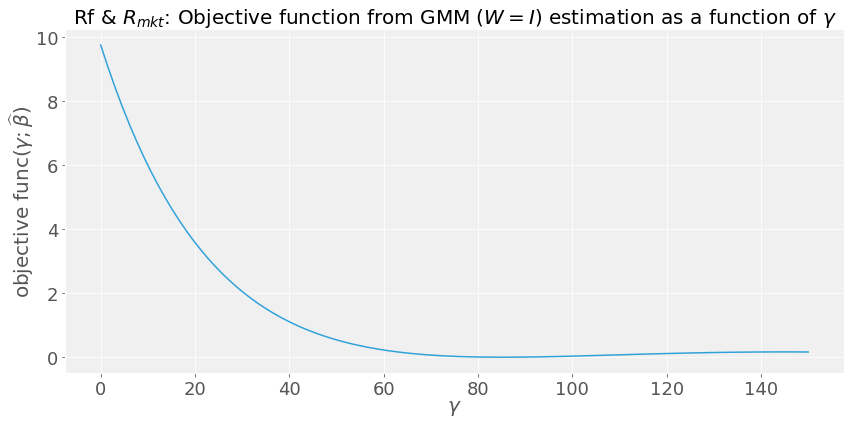

In [77]:
### Plot of objfunction(gamma; beta_hat) vs. gamma (W = I)
N = 100
gamma_array = np.linspace(0, 150, num=N)
objfunc_array = np.zeros(N)
for ii in range(N):
    objfunc_array[ii] = get_objfunc(df_alldata['c_growth'], 
                                    df_alldata[['RF', 'R_mkt_rate']], 
                                    beta_hat, gamma_array[ii], W=Wid)
plt.plot(gamma_array, objfunc_array)

plt.ylabel(r'objective func($\gamma; \widehat{\beta}$)',fontsize=20)
plt.xlabel(r'$\gamma$', fontsize=20)
plt.title('Rf & $R_{mkt}$: Objective function from GMM $(W = I)$ estimation as a function of $\gamma$', fontsize=20)
plt.tight_layout()

### Model 1: 
Since we use Method of Moments (**MM**), $W$ doesn't play a role and we get the same estimates with the **1-step GMM estimator** using $W=S^{-1}$:

In [78]:
### (W = S^1)
ccapm_res1 = ccapm_model1.fit(np.array([0,0]), maxiter=2, optim_args={'gtol':1e-9}) # note: default tolerance is too large
print(ccapm_res1.summary(xname=['beta (discount factor)', 'gamma (CRRA)']))

### GMM estimates (W =  S^1)
beta_hat, gamma_hat = ccapm_res1.params
print('beta (discount factor): ', beta_hat, '\n')
print('gamma (CRRA): ', gamma_hat, '\n')

### GMM optimal weighting matrix W = S^-1
optimalW = ccapm_res1.weights
print('weighting matrix W: ')
print(optimalW)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 73
         Function evaluations: 97
         Gradient evaluations: 97
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
                              CCAPM_GMM Results                               
Dep. Variable:               c_growth   Hansen J:                    9.012e-16
Model:                      CCAPM_GMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Fri, 26 Apr 2019                                         
Time:                        17:10:15                                         
No. Observations:                 231                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
---------------

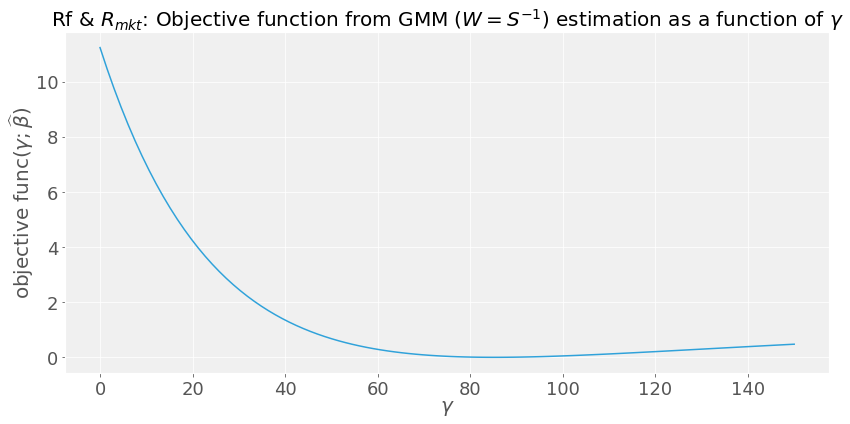

In [79]:
### Plot of objfunction(gamma; beta_hat) vs. gamma (W =  S^1)
N = 100
gamma_array = np.linspace(0, 150, num=N)
objfunc_array = np.zeros(N)
for ii in range(N):
    objfunc_array[ii] = get_objfunc(df_alldata['c_growth'], 
                                    df_alldata[['RF', 'R_mkt_rate']], 
                                    beta_hat, gamma_array[ii], W=optimalW)
plt.plot(gamma_array, objfunc_array)

plt.ylabel(r'objective func($\gamma; \widehat{\beta}$)',fontsize=20)
plt.xlabel(r'$\gamma$', fontsize=20)
plt.title('Rf & $R_{mkt}$: Objective function from GMM $(W = S^{-1})$ estimation as a function of $\gamma$', 
          fontsize=20)
plt.tight_layout()

### Model 2: 
We now estimate our model via **GMM** using the risk-free asset, market return and six Fama-French portfolio returns. We start with $W=I$:

In [80]:
### Set up model 2: with the 6 Fama-French portfolio returns; just the return on the market
ccapm_model2 = CCAPM_GMM(df_alldata[['c_growth']],
                         df_alldata[['RF', 'R_mkt_rate', 'B/L', 'B/M', 'B/H', 'S/L', 'S/M', 'S/H']])

### (W = I)
ccapm_res2 = ccapm_model2.fit(np.array([0,0]), maxiter=1, optim_args={'gtol':1e-9}) # note: default tolerance is too large
print(ccapm_res2.summary(xname=['delta: discount factor', 'gamma: CRRA']))

### GMM estimates (W = I)
beta_hat, gamma_hat = ccapm_res2.params
print('beta (discount factor): ', beta_hat, '\n')
print('gamma (CRRA): ', gamma_hat, '\n')

### GMM eighting matrix W = I
Wid = ccapm_res2.weights
print('weighting matrix W: ')
print(Wid)

Optimization terminated successfully.
         Current function value: 0.000116
         Iterations: 67
         Function evaluations: 87
         Gradient evaluations: 87
                              CCAPM_GMM Results                               
Dep. Variable:               c_growth   Hansen J:                      0.02683
Model:                      CCAPM_GMM   Prob (Hansen J):                  1.00
Method:                           GMM                                         
Date:                Fri, 26 Apr 2019                                         
Time:                        17:10:20                                         
No. Observations:                 231                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
delta: discount factor     3.0945      0.956      3.237      0.001       1.221       4.968
ga

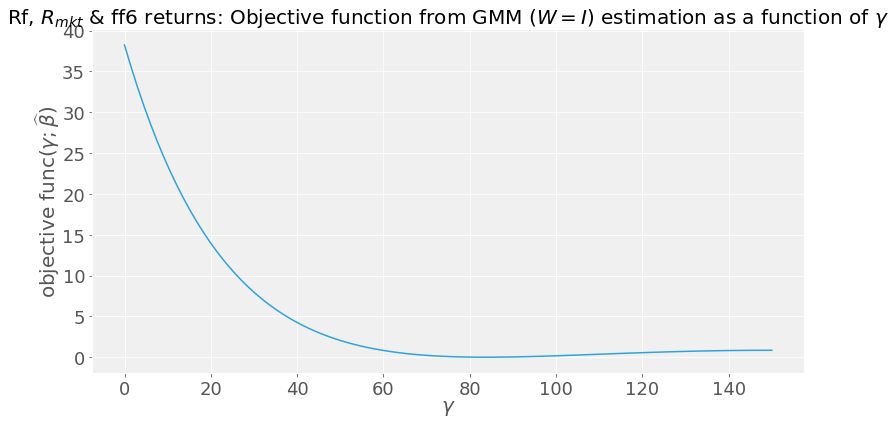

In [81]:
### Plot of objfunction(gamma; beta_hat) vs. gamma
N = 100
gamma_array = np.linspace(0, 150, num=N)
objfunc_array = np.zeros(N)
for ii in range(N):
    objfunc_array[ii] = get_objfunc(df_alldata['c_growth'], 
                                    df_alldata[['RF', 'R_mkt_rate', 'B/L', 'B/M', 'B/H', 'S/L', 'S/M', 'S/H']], 
                                    beta_hat, gamma_array[ii], W=Wid)
plt.plot(gamma_array, objfunc_array)

plt.ylabel(r'objective func($\gamma; \widehat{\beta}$)', fontsize=20)
plt.xlabel(r'$\gamma$', fontsize=20)
plt.title('Rf, $R_{mkt}$ & ff6 returns: Objective function from GMM $(W= I)$ estimation as a function of $\gamma$',
          fontsize=20)
plt.tight_layout()

### Model 2: 
We now consider the **1-step GMM estimator** with $W=S^{-1}$:

In [82]:
### (W = S^-1)
ccapm_res2 = ccapm_model2.fit(np.array([0,0]), maxiter=2, optim_args={'gtol':1e-9}) # note: default tolerance is too large
print(ccapm_res2.summary(xname=['delta: discount factor', 'gamma: CRRA']))

### GMM estimates (W = S^-1)
beta_hat, gamma_hat = ccapm_res2.params
print('beta (discount factor): ', beta_hat, '\n')
print('gamma (CRRA): ', gamma_hat, '\n')

### GMM eighting matrix W = S^-1
optimalW = ccapm_res2.weights
print('weighting matrix W: ')
print(optimalW)


Optimization terminated successfully.
         Current function value: 0.000116
         Iterations: 67
         Function evaluations: 87
         Gradient evaluations: 87
         Current function value: 0.079805
         Iterations: 40
         Function evaluations: 96
         Gradient evaluations: 86
                              CCAPM_GMM Results                               
Dep. Variable:               c_growth   Hansen J:                        18.44
Model:                      CCAPM_GMM   Prob (Hansen J):               0.00523
Method:                           GMM                                         
Date:                Fri, 26 Apr 2019                                         
Time:                        17:10:33                                         
No. Observations:                 231                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

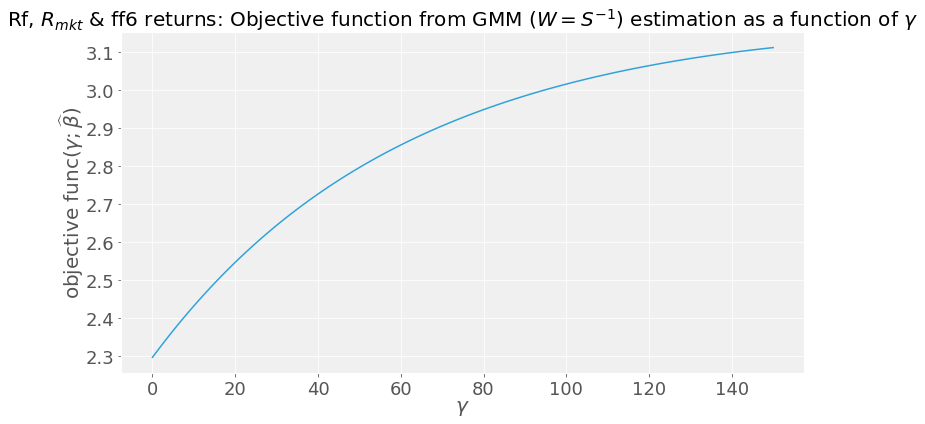

In [83]:
### Plot of objfunction(gamma; beta_hat) vs. gamma
N = 100
gamma_array = np.linspace(0, 150, num=N)
objfunc_array = np.zeros(N)
for ii in range(N):
    objfunc_array[ii] = get_objfunc(df_alldata['c_growth'], 
                                    df_alldata[['RF', 'R_mkt_rate', 'B/L', 'B/M', 'B/H', 'S/L', 'S/M', 'S/H']], 
                                    beta_hat, gamma_array[ii], W=optimalW)
plt.plot(gamma_array, objfunc_array)

plt.ylabel(r'objective func($\gamma; \widehat{\beta}$)', fontsize=20)
plt.xlabel(r'$\gamma$', fontsize=20)
plt.title('Rf, $R_{mkt}$ & ff6 returns: Objective function from GMM $(W=S^{-1})$ estimation as a function of $\gamma$', 
          fontsize=20)
plt.tight_layout()


### Digression: Inverting matrices and potential instabilities 

This code will illustrate the difficulty in inverting matrices. 

The code uses the $2^{nd}$ moment matrix of $1+R$, $RR$ from before. 

The $S$ matrix should be similar to that of the $2^{nd}$ moment matrix. The code first inverts $RR$. Then it adds a little bit of noise to $RR$ and inverts it again. Even though the $RR$ matrices are very similar, their inverses are NOT!

In [84]:
R = 1 + df_alldata[['RF', 'R_mkt_rate', 'B/L', 'B/M', 'B/H', 'S/L', 'S/M', 'S/H']]

In [85]:
RR = np.dot(R.T,R)/Nobs

print('RR')
print(RR)
print('\nRR Condition number',np.linalg.cond(RR))
print('\nRR inverse\n',np.linalg.inv(RR))

RR2 = RR + 0.01*np.random.normal(size=RR.shape)

print('\nRR2')
print(RR2)
print('\nRR2 Condition number',np.linalg.cond(RR2))
print('\nRR2 inverse\n',np.linalg.inv(RR2))

print('\nRR-RR2\n',RR-RR2)
print('\nRRinverse-RR2inverse\n',np.linalg.inv(RR)-np.linalg.inv(RR2))

RR
[[1.023 1.04  1.038 1.04  1.044 1.042 1.049 1.055]
 [1.04  1.064 1.062 1.063 1.068 1.069 1.074 1.08 ]
 [1.038 1.062 1.061 1.061 1.066 1.067 1.072 1.078]
 [1.04  1.063 1.061 1.063 1.068 1.067 1.074 1.08 ]
 [1.044 1.068 1.066 1.068 1.074 1.072 1.079 1.086]
 [1.042 1.069 1.067 1.067 1.072 1.078 1.082 1.087]
 [1.049 1.074 1.072 1.074 1.079 1.082 1.088 1.094]
 [1.055 1.08  1.078 1.08  1.086 1.087 1.094 1.102]]

RR Condition number 297390.0329227432

RR inverse
 [[ 2.248e+02 -2.548e+02  4.033e+01 -1.169e+02  1.441e+01  1.542e+02
  -1.565e+02  9.879e+01]
 [-2.548e+02  2.550e+04 -1.278e+04 -7.503e+03 -3.137e+03 -2.216e+03
   7.114e+02 -3.266e+02]
 [ 4.033e+01 -1.278e+04  7.553e+03  3.035e+03  1.273e+03  5.811e+02
  -3.857e+02  6.828e+02]
 [-1.169e+02 -7.503e+03  3.035e+03  3.909e+03  3.806e+02  9.252e+02
  -7.755e+02  1.488e+02]
 [ 1.441e+01 -3.137e+03  1.273e+03  3.806e+02  1.539e+03  4.951e+02
   1.368e+02 -6.971e+02]
 [ 1.542e+02 -2.216e+03  5.811e+02  9.252e+02  4.951e+02  9.277e+02
  -

In [86]:
RR2 = RR + 0.01*np.random.normal(size=RR.shape)

print(RR2)
print('\n',np.linalg.cond(RR2))
print('\n',np.linalg.inv(RR2))

print(RR-RR2)
print('\n',np.linalg.inv(RR)-np.linalg.inv(RR2))

[[1.023 1.027 1.024 1.035 1.052 1.048 1.056 1.061]
 [1.053 1.043 1.054 1.059 1.053 1.046 1.068 1.071]
 [1.049 1.065 1.045 1.052 1.066 1.072 1.06  1.09 ]
 [1.028 1.052 1.06  1.054 1.079 1.069 1.079 1.082]
 [1.048 1.062 1.06  1.067 1.052 1.075 1.08  1.078]
 [1.05  1.062 1.063 1.068 1.059 1.069 1.082 1.08 ]
 [1.038 1.082 1.064 1.088 1.084 1.088 1.082 1.072]
 [1.043 1.094 1.055 1.089 1.08  1.107 1.114 1.084]]

 51758.25246572019

 [[ -642.452   898.141   162.246   449.94    720.176 -1731.763  -164.292
    301.249]
 [ -319.374   367.288    95.027   196.845   234.719  -653.097   -72.782
    147.077]
 [ -401.926   500.199    82.705   295.371   435.742  -983.628   -88.577
    155.669]
 [ 1086.155 -1423.989  -273.457  -788.153 -1147.43   2772.986   287.546
   -501.184]
 [ -326.002   462.445    82.889   249.206   333.05   -888.841   -70.771
    154.633]
 [ -326.76    453.163    77.758   250.999   472.344 -1001.354   -78.331
    148.976]
 [ -147.92    201.778    19.922   112.946   129.459  -349.3

That is all for today! 😎